In [1]:
import sys
import pickle
import operator
from time import time
import warnings
import pandas as pd
from data_structure.dataset import Dataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import ensemble
import seaborn as sns
from matplotlib import pyplot as plt
from utils.Utilities import *
warnings.filterwarnings('ignore')

- Import Data

In [2]:
import os
if os.path.isfile('data/ai4fit_data.csv'):
    ai4fit_data = pd.read_csv('data/ai4fit_data.csv')

- Considered columns

In [3]:
columns = ['mean_rating',
 'r_distance',
 'calories',
 'd_distance_sum',
 'd_pace_mean',
 'd_distance_var',
 'd_distance_std',
 'd_time_std',
 'd_time_sum',
 'd_time_var',
 'r_time',
 'r_pace',
 'd_pace_var',
 'd_pace_std',
 'o_pace',
 'o_time',
 'bmi',
 'o_distance',
 'p_welldone',
 'weeknumber',
 'p_running',
 'weight',
 'user_pop',
 'p_has_objective',
 'age',
 'height',
 'weekday',
 'p_walking',
 'month',
 'days_from_previous']

In [4]:
len(columns)

30

- Take the last workout perfromed by each user

In [5]:
test_set = pd.DataFrame(columns=ai4fit_data.columns)
i = 0
for u_id in ai4fit_data.user_id.unique():
    row = ai4fit_data[ai4fit_data.user_id==u_id].sort_values(by=['w_id'],ascending=False).iloc[0]
    test_set.loc[i] = row
    i=i+1

test_set.drop_duplicates('user_id',keep='last',inplace=True)

print("In total: ", test_set.shape)
test_set.head(5).append(test_set.tail(5))

In total:  (291, 41)


,w_id,user_id,trainer_id,o_distance,o_time,o_pace,d_distance_sum,d_distance_std,d_distance_var,d_time_sum,...,workout_date,mean_rating,rating,month,weekday,weeknumber,year,days_from_previous,user_pop,dec_user_pop
0,142125,12931,4842,8000,3820,64.000000,0.437333,0.174933,3.060167e-02,1.329609,...,2018-07-16 15:46:29,2.75,2,7,0,29,2018,0,4,2.75
1,142026,7108,2,6000,1980,165.000000,0.000000,0.000000,0.000000e+00,-0.016396,...,2018-05-15 17:14:47,4.75,5,5,1,20,2018,4,1,0.00
2,145382,12508,4198,10000,0,0.000000,-0.000053,0.000026,7.021383e-10,0.000000,...,2018-07-16 15:57:38,5.00,5,7,0,29,2018,0,13,11.75
3,156978,12752,2,5000,1700,170.000000,-0.000422,0.000211,4.450504e-08,0.055294,...,2018-09-01 16:51:09,4.25,5,9,5,35,2018,24,30,28.75
4,165371,418,26,10000,4665,167.727273,0.000000,0.000000,0.000000e+00,0.856130,...,2018-11-17 09:13:48,4.50,5,11,5,46,2018,14,159,157.75
286,161096,15330,9929,10000,0,0.000000,-0.000160,0.000080,6.428629e-09,0.000000,...,2018-10-10 19:24:25,3.00,3,10,2,41,2018,6,5,3.75
287,165016,14603,9223,10000,0,0.000000,-0.000169,0.000084,7.124571e-09,0.000000,...,2018-11-14 08:28:46,3.00,3,11,2,46,2018,7,5,3.75
288,165087,15924,9929,12000,0,0.000000,0.303466,0.151733,2.302298e-02,0.000000,...,2018-11-14 20:23:03,3.00,3,11,2,46,2018,11,3,1.75
289,164905,15611,9223,9200,2920,295.000000,0.000000,0.000000,0.000000e+00,-0.244945,...,2018-11-17 10:42:06,4.25,4,11,5,46,2018,7,4,2.75
290,164316,16004,9929,4800,1740,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,2018-11-08 16:49:31,3.75,4,11,3,45,2018,0,0,0.00


In [6]:
training_set = ai4fit_data.loc[~ai4fit_data['w_id'].isin(test_set.w_id.values)]
print("In total: ", training_set.shape)
training_set.head(5).append(training_set.tail(5))

In total:  (5532, 41)


,w_id,user_id,trainer_id,o_distance,o_time,o_pace,d_distance_sum,d_distance_std,d_distance_var,d_time_sum,...,workout_date,mean_rating,rating,month,weekday,weeknumber,year,days_from_previous,user_pop,dec_user_pop
0,141355,12931,4842,2000,1200,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,2018-05-11 12:22:16,5.00,5,5,4,19,2018,0,0,0.00
1,141357,7108,2,6000,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,2018-05-11 14:58:12,4.00,4,5,4,19,2018,0,0,0.00
2,141412,12508,4198,8400,1800,0.000000,-0.073392,0.003561,1.268350e-05,-0.093333,...,2018-05-11 22:22:41,4.00,4,5,4,19,2018,0,0,0.00
3,141408,12752,2,5550,2025,336.428571,-0.095826,0.005754,3.310457e-05,0.124786,...,2018-05-12 06:10:13,4.00,4,5,5,19,2018,0,0,0.00
4,141432,418,26,13000,5340,117.500000,0.000000,0.000000,0.000000e+00,1.059476,...,2018-05-12 06:39:48,5.00,5,5,5,19,2018,0,0,0.00
5804,164449,3678,9223,4800,2664,37.058824,0.004113,0.003608,1.301646e-05,0.726587,...,2018-11-09 12:11:21,3.00,3,11,4,45,2018,3,21,19.75
5805,164483,15611,9223,18000,5940,165.000000,0.000000,0.000000,0.000000e+00,-0.011873,...,2018-11-10 06:35:23,5.00,5,11,5,45,2018,3,3,1.75
5806,164758,3678,9223,4500,2331,84.375000,-0.006348,0.001395,1.947032e-06,-0.837792,...,2018-11-12 12:02:06,2.25,2,11,0,46,2018,3,22,20.75
5807,164851,13581,9223,5000,2100,210.000000,-0.001149,0.000575,3.302977e-07,0.063810,...,2018-11-13 10:18:05,5.00,5,11,1,46,2018,24,13,11.75
5809,165099,1671,57,10000,575,143.750000,0.000000,0.000000,0.000000e+00,-0.185375,...,2018-11-14 20:22:52,3.75,4,11,2,46,2018,18,40,38.75


- Calculate the user popularity for each user

In [7]:
test_set['user_pop'] = ['NaN'] * len(test_set.user_id.values)

for u in test_set.user_id.unique():
    test_set.loc[test_set['user_id'] == u, 'user_pop'] = len(training_set[training_set['user_id'] == u].values)

- Select the trainers that have at least 10 users

In [8]:
trainers = ai4fit_data.trainer_id.unique()
users = [ai4fit_data[ai4fit_data.trainer_id==t_id].shape[0] for t_id in trainers]
men = [ai4fit_data[(ai4fit_data.trainer_id==t_id) & (ai4fit_data.gender==1)].shape[0] for t_id in trainers]
women = [ai4fit_data[(ai4fit_data.trainer_id==t_id) & (ai4fit_data.gender==0)].shape[0] for t_id in trainers]

trainers_df = pd.DataFrame({'trainer_id':trainers,'n_users':users,'men':men,'women':women})
valid_trainers = trainers_df[trainers_df.n_users>=10]
print("In total: ", ai4fit_data.shape)
valid_trainers#.head(5).append(valid_trainers.tail(5))

In total:  (5823, 41)


,trainer_id,n_users,men,women
0,4842,143,19,124
1,2,1055,801,254
2,4198,361,235,126
3,26,951,388,563
4,9928,117,117,0
5,5200,505,345,160
6,9223,260,89,171
7,31,454,405,49
8,2155,399,354,45
9,5201,136,4,132


- Select the workouts performed by users supervised by the valid trainers (That follow at least 10 users) 

In [9]:
test_set = test_set[test_set.trainer_id.isin(valid_trainers.trainer_id.values)]
test_set.head(5).append(test_set.tail(5))

,w_id,user_id,trainer_id,o_distance,o_time,o_pace,d_distance_sum,d_distance_std,d_distance_var,d_time_sum,...,workout_date,mean_rating,rating,month,weekday,weeknumber,year,days_from_previous,user_pop,dec_user_pop
0,142125,12931,4842,8000,3820,64.000000,0.437333,0.174933,3.060167e-02,1.329609,...,2018-07-16 15:46:29,2.75,2,7,0,29,2018,0,4,2.75
1,142026,7108,2,6000,1980,165.000000,0.000000,0.000000,0.000000e+00,-0.016396,...,2018-05-15 17:14:47,4.75,5,5,1,20,2018,4,182,0.00
2,145382,12508,4198,10000,0,0.000000,-0.000053,0.000026,7.021383e-10,0.000000,...,2018-07-16 15:57:38,5.00,5,7,0,29,2018,0,13,11.75
3,156978,12752,2,5000,1700,170.000000,-0.000422,0.000211,4.450504e-08,0.055294,...,2018-09-01 16:51:09,4.25,5,9,5,35,2018,24,30,28.75
4,165371,418,26,10000,4665,167.727273,0.000000,0.000000,0.000000e+00,0.856130,...,2018-11-17 09:13:48,4.50,5,11,5,46,2018,14,159,157.75
286,161096,15330,9929,10000,0,0.000000,-0.000160,0.000080,6.428629e-09,0.000000,...,2018-10-10 19:24:25,3.00,3,10,2,41,2018,6,5,3.75
287,165016,14603,9223,10000,0,0.000000,-0.000169,0.000084,7.124571e-09,0.000000,...,2018-11-14 08:28:46,3.00,3,11,2,46,2018,7,5,3.75
288,165087,15924,9929,12000,0,0.000000,0.303466,0.151733,2.302298e-02,0.000000,...,2018-11-14 20:23:03,3.00,3,11,2,46,2018,11,3,1.75
289,164905,15611,9223,9200,2920,295.000000,0.000000,0.000000,0.000000e+00,-0.244945,...,2018-11-17 10:42:06,4.25,4,11,5,46,2018,7,4,2.75
290,164316,16004,9929,4800,1740,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,2018-11-08 16:49:31,3.75,4,11,3,45,2018,0,0,0.00


- Load the classifier

In [10]:
pkl_filename = "/Users/walidiguider/PycharmProjects/MLOps/best_rf_classifier.pkl"
#loaded_model = pickle.load(open(pkl_filename, 'rb'))

- Evaluate the classifier

In [11]:
import mord as m
from sklearn.metrics import accuracy_score
X_test = test_set[columns]
y_test = test_set.rating.values

oc = m.OrdinalRidge()
oc.fit(training_set[columns],training_set.rating.values)
y_pred = oc.predict(X_test)
accuracy_score(list(y_test),list(y_pred))

0.9206896551724137

- Predict ratings

In [12]:
# Predicted Ratings
test_set['p_rating'] = oc.predict(test_set[columns])

- Rank calculation functions

In [13]:
def normalize(x):
    return(x+-min(x))/(max(x)-min(x))

In [14]:
def calculate_possible_growth_rank(rating):
    k = 100*(rating-5)/5
    rank = rating + k
    return (normalize(rank)*100) + 1

def calculate_recent_growth_rank(rating, mean_rating):
    h = 100*(rating-mean_rating)/mean_rating
    rank = rating + h
    return (normalize(rank)*100) + 1

def calculate_popularity_based_rank(rating, popularity):
    # if the users has performed a lot of workouts 
    # and obtains a low rating => they need more attention
    rank = 100*rating/(1+popularity)
    return (normalize(rank)*100) + 1

In [15]:
def ratingBasedRanking(R):
    return R.sort_values('rating')

def popularityBasedRanking(R):
    R['pop_rank'] = calculate_popularity_based_rank(R.rating, R.user_pop)
    return R.sort_values('pop_rank')
    
def possibleGrowthRanking(R):
    R['possible_growth'] = calculate_possible_growth_rank(R.rating)
    return R.sort_values('possible_growth')

def recentGrowthRanking(R):
    R['recent_growth'] = calculate_recent_growth_rank(R.rating, R.mean_rating)
    return R.sort_values('recent_growth')

In [16]:
def calculateExposure(top_10, rank_col):
    """
    exposure = position bias (1/log(1+position))
    top_10_ should be already sorted by rank_col
    """
    try:
        top_10_ = top_10.sort_values(rank_col,kind='mergesort')
        return np.array([1.0/(np.log2(2 + i)) for i, _ in enumerate(top_10_[rank_col].values)])
    except Exception as e:
        print(top_10)
        print(e)

In [17]:
def calculateRelevance(R, rank_col, asc=False):
    R = R.sort_values(rank_col, ascending=asc,kind='mergesort')
    return normalize(R[rank_col].max()- R[rank_col])

In [18]:
def calculateDocumentUtility(relevance, position):
    """
    Document Utility = DCG = 2ˆrel - 1/log(1+j)
    The utility of a single element in the ranking
    """
    utility = ((2**relevance)-1)/np.log2(2+position)
    if np.isnan(utility):
        utility = 1
    return utility

In [19]:
def calculateUtility(top_10, rank_col, rel_col):
    """
    The utility w.r.t. the raking 
    """
    top_10_ = top_10.sort_values(rank_col,kind='mergesort')
    return np.array([calculateDocumentUtility(top_10_.iloc[[j]][rel_col].values[0], j) for j, _ in enumerate(top_10_[rank_col].values)])


In [20]:
def calculateDTR(top_10, rank_col, rel_col):
    """
    The disparate treatment ratio of G_0/G_1
    """
    try:
        top_10['exposure'] = calculateExposure(top_10, rank_col)
        top_10['utility'] = 1+calculateUtility(top_10, rank_col, rel_col)

        avg_utility_1 = round(np.average(top_10[top_10.gender==0].utility.values),3)
        avg_utility_2 = round(np.average(top_10[top_10.gender==1].utility.values),3)

        avg_exposure_1  = round(np.average(top_10[top_10.gender==0].exposure.values),3)
        
        avg_exposure_2  = round(np.average(top_10[top_10.gender==1].exposure.values),3)
        if top_10[top_10.gender==0].shape[0] == top_10.shape[0] or top_10[top_10.gender==1].shape[0] == top_10.shape[0]:
            return 1
        elif avg_utility_1 > 0 and avg_utility_2 > 0 and avg_exposure_1  > 0 and avg_exposure_2 >0:
            DT_1 = (avg_exposure_1/avg_utility_1)
            DT_2 = (avg_exposure_2/avg_utility_2)
            return round(DT_1/DT_2,3)
        else:
            print('ERROR',avg_exposure_1, avg_exposure_2,avg_utility_1,avg_utility_2)
            return -1
    except Exception as e:
        print(top_10)
        print(e)

In [21]:
def calculateDPR(top_10, rank_col, rel_col):
    """
    The demographic parity ratio of G_0/G_1
    """
    top_10['exposure'] = calculateExposure(top_10, rank_col)

    avg_exposure_1  = round(np.average(top_10[top_10.gender==0].exposure.values),3)
    avg_exposure_2  = round(np.average(top_10[top_10.gender==1].exposure.values),3)
    
    if top_10[top_10.gender==0].shape[0] == top_10.shape[0] or top_10[top_10.gender==1].shape[0] == top_10.shape[0]:
        return 1
    elif avg_exposure_1  > 0 and avg_exposure_2 >0:
        return round((avg_exposure_1)/(avg_exposure_2),3)
    else:
        print('ERROR')
        return -1

In [22]:
test_set.trainer_id.value_counts()

26       50
2        39
2155     28
4198     26
9223     18
31       15
9929     12
5200     12
4842     11
44       10
2588      9
57        9
33        8
34        6
4385      5
5673      4
36        4
9477      4
5204      4
9928      4
262       3
5201      3
5203      3
14490     2
41        1
Name: trainer_id, dtype: int64

In [23]:
test_set.columns

Index(['w_id', 'user_id', 'trainer_id', 'o_distance', 'o_time', 'o_pace',
       'd_distance_sum', 'd_distance_std', 'd_distance_var', 'd_time_sum',
       'd_time_std', 'd_time_var', 'd_pace_mean', 'd_pace_std', 'd_pace_var',
       'r_distance', 'r_speed', 'r_time', 'r_pace', 'p_running', 'p_walking',
       'p_unknown', 'p_welldone', 'p_has_objective', 'age', 'height', 'weight',
       'gender', 'bmi', 'weight_situation', 'calories', 'workout_date',
       'mean_rating', 'rating', 'month', 'weekday', 'weeknumber', 'year',
       'days_from_previous', 'user_pop', 'dec_user_pop', 'p_rating'],
      dtype='object')

In [24]:
input_df = test_set[['trainer_id', 'user_id', 'gender', 'user_pop', 'mean_rating', 'rating','p_rating']]
input_df[input_df.trainer_id==4842]

,trainer_id,user_id,gender,user_pop,mean_rating,rating,p_rating
0,4842,12931,0,4,2.75,2,3.0
5,4842,11545,0,60,3.25,3,3.0
8,4842,11364,0,10,4.00,4,4.0
10,4842,11808,1,2,5.00,5,5.0
13,4842,13052,0,3,5.00,5,5.0
21,4842,13162,0,4,3.50,3,4.0
104,4842,5283,0,18,2.25,2,2.0
212,4842,9255,1,5,4.00,4,4.0
233,4842,9842,0,2,3.00,3,3.0
261,4842,12176,0,15,2.50,2,2.0


In [25]:
class Ranking():
    def __init__(self, input_df=None):
        self.input_df = input_df
        self.predicted_ranking = None
        self.ndcg =''
        self.dtr =''
        self.dpr =''
        self.fair_ranking_dtr = None
        self.fair_ranking_dpr = None
        self._baseline =  self.baseline()
        self._predicted = self.predicted()
        
    def calculate_measures(self, resort=True):
        if resort:
            self.baseline()
            self.predicted()
            
        self.input_df = self.input_df.sort_values(self._baseline,kind='mergesort')
        self.input_df['rank'] = [i for i, _ in enumerate(self.input_df.values)]
        self.input_df['relevance'] = calculateRelevance(self.input_df, self._baseline)

        self.input_df = self.input_df.sort_values(self._predicted,kind='mergesort')
        self.input_df['p_rank'] = [i for i, _ in enumerate(self.input_df.values)]
        self.input_df['p_relevance'] = calculateRelevance(self.input_df, self._predicted)
        
        self.dtr = calculateDTR(self.input_df.sort_values('p_relevance',ascending=False,kind='mergesort'),'p_rank','p_relevance')
        self.dpr = calculateDPR(self.input_df.sort_values('p_relevance',ascending=False,kind='mergesort'),'p_rank','p_relevance')
        self.ndcg = ndcg_at_k(self.input_df.sort_values('relevance',ascending=False,kind='mergesort')['p_relevance'].values,10)
        print('calculate_measures')
        print('NDCG: ', self.ndcg)
        print('DTR: ', self.dtr)
        print('DPR: ', self.dpr)
        
    def baseline(self):
        pass
    
    def predicted(self):
        pass
    
    def freeze(self, d):
        if isinstance(d, dict):
            return frozenset((key, self.freeze(value)) for key, value in d.items())
        elif isinstance(d, list):
            return tuple(self.freeze(value) for value in d)
        return d

    def swap_rows(self, df, idx1, idx2, fairness_metric):
        b, c = df.iloc[idx1].copy(), df.iloc[idx2].copy()
        df.iloc[idx1],df.iloc[idx2] = c,b
        return df, fairness_metric(self.input_df,'p_rank','p_relevance')

    def getRowsToSwap(self, gender_list, disadvantaged_gender):
        cols = []
        if disadvantaged_gender == 1:
            for i in range(len(gender_list)):
                if i<len(gender_list)-1 and gender_list[i]==0 and gender_list[i+1]==1:
                    cols.append([i,i+1])    
        if disadvantaged_gender == 0:
            for i in range(len(gender_list)):
                if i<len(gender_list)-1 and gender_list[i]==1 and gender_list[i+1]==0:
                     cols.append([i,i+1])
        return cols

    def orderRerank(self, fairness_metric):
        d = {}
        s = {}

        _t10 = self.input_df.sort_values(self._predicted,kind='mergesort').copy()
        original = self.input_df.sort_values(self._predicted,kind='mergesort').copy()
        #print(original.columns)
        #print('Before')
        #print('NDCG: ', ndcg_at_k(original.sort_values('relevance',ascending=False,kind='mergesort')['p_relevance'],10))
        #print('DTR: ', calculateDTR(original,'p_rank','p_relevance'))
        #print('DPR: ', calculateDPR(original,'p_rank','p_relevance'))
        if fairness_metric == calculateDTR:
            _dtr = self.dtr
        else:
            _dtr = self.dpr
        
        d[self.freeze(_t10.to_dict())] = abs(1-_dtr)
        gender_list = _t10.gender.values
        disadvantaged_gender = int(_dtr<1)
        r = self.getRowsToSwap(gender_list, disadvantaged_gender)
        s[self.freeze(_t10.to_dict())] = r

        try:
            while (len(s[self.freeze(_t10.to_dict())])>0):
                p = s[self.freeze(_t10.to_dict())][0] # random pair
                del s[self.freeze(_t10.to_dict())][0] #remove p from s
                # first swap
                t10_temp, dtr_temp = self.swap_rows(_t10,p[0],p[1],fairness_metric)
                if abs(1-_dtr)>abs(1-dtr_temp):
                    _t10 = t10_temp.copy()
                    _dtr = dtr_temp.copy()
                    d[self.freeze(_t10.to_dict())] = abs(1-_dtr)
                    gender_list = _t10.gender.values
                    disadvantaged_gender = int(_dtr<1)
                    r = self.getRowsToSwap(gender_list, disadvantaged_gender)
                    s[self.freeze(_t10.to_dict())] = r
        except Exception as e:
            pass


        sorted_d = sorted(d.items(), key=operator.itemgetter(1))
        res = pd.DataFrame()
        for x,y in list(sorted_d[0][0]):
            v = []
            for a,b in y:
                v.append(b)
            res[x] = list(v)

        if abs(1-fairness_metric(original,'p_rank','p_relevance'))>abs(1-fairness_metric(res,'p_rank','p_relevance')):
            #print('After')
            #print('new',_t10.trainer_id.values[0])
            #print('NDCG: ', ndcg_at_k(res['p_relevance'],10))
            #print('DTR: ', calculateDTR(res,'p_rank','p_relevance'))
            #print('DPR: ', calculateDPR(res,'p_rank','p_relevance'))
            return res
        else:
            #print('After')
            #print('original',_t10.trainer_id.values[0])
            #print('NDCG: ', ndcg_at_k(original['p_relevance'],10))
            #print('DTR: ', calculateDTR(original,'p_rank','p_relevance'))
            #print('DPR: ', calculateDPR(original,'p_rank','p_relevance'))
            return original
        
        
    def get_fair_ranking(self):
        self.fair_ranking_dtr = Ranking()
        
        self.fair_ranking_dtr._baseline = self._baseline
        self.fair_ranking_dtr._predicted = self._predicted
        self.fair_ranking_dtr.input_df = self.orderRerank(calculateDTR)
        #print(calculateDTR(self.fair_ranking_dtr.input_df,'p_rank','p_relevance'))
        self.fair_ranking_dtr.ndcg = ndcg_at_k(self.fair_ranking_dtr.input_df['p_relevance'],10)
        self.fair_ranking_dtr.dtr = calculateDTR(self.fair_ranking_dtr.input_df,'p_rank','p_relevance')
        self.fair_ranking_dtr.dpr = calculateDPR(self.fair_ranking_dtr.input_df,'p_rank','p_relevance')
        self.fair_ranking_dpr = Ranking()
        self.fair_ranking_dpr._baseline = self._baseline
        self.fair_ranking_dpr._predicted = self._predicted
        self.fair_ranking_dpr.input_df = self.orderRerank(calculateDPR)
        
        self.fair_ranking_dpr.ndcg = ndcg_at_k(self.fair_ranking_dpr.input_df['p_relevance'],10)
        self.fair_ranking_dpr.dtr = calculateDTR(self.fair_ranking_dpr.input_df,'p_rank','p_relevance')
        self.fair_ranking_dpr.dpr = calculateDPR(self.fair_ranking_dpr.input_df,'p_rank','p_relevance')
    
    
class RatingBasedRanking(Ranking):
    def baseline(self):
        self.input_df = self.input_df.sort_values('rating',kind='mergesort')
        self._baseline = 'rating'
        return 'rating'
    
    def predicted(self):
        self.input_df = self.input_df.sort_values('p_rating',kind='mergesort')
        self.predicted_ranking = self.input_df.sort_values('p_rating')
        self._predicted = 'p_rating'
        return 'p_rating'
    
    
class PopularityBasedRanking(Ranking):
    def baseline(self):
        self.input_df['pop_rank'] = calculate_popularity_based_rank(self.input_df.rating, self.input_df.user_pop)
        self.input_df = self.input_df.sort_values('pop_rank',kind='mergesort')
        return 'pop_rank'
    
    def predicted(self):
        self.input_df['p_pop_rank'] = calculate_popularity_based_rank(self.input_df.p_rating, self.input_df.user_pop)
        self.input_df = self.input_df.sort_values('p_pop_rank',kind='mergesort')
        self.predicted_ranking = self.input_df.sort_values('p_pop_rank',kind='mergesort')
        return 'p_pop_rank'
    
    
class PossibleGrowthRanking(Ranking):
    def baseline(self):
        self.input_df['possible_growth'] = calculate_possible_growth_rank(self.input_df.rating)
        self.input_df = self.input_df.sort_values('possible_growth',kind='mergesort')
        return 'possible_growth'
    
    def predicted(self):
        self.input_df['p_possible_growth'] = calculate_possible_growth_rank(self.input_df.p_rating)
        self.input_df = self.input_df.sort_values('p_possible_growth')
        self.predicted_ranking = self.input_df.sort_values('p_possible_growth',kind='mergesort')
        return 'p_possible_growth'

    
class RecentGrowthRanking(Ranking):
    def baseline(self):
        self.input_df['recent_growth'] = calculate_recent_growth_rank(self.input_df.rating, self.input_df.mean_rating)
        self.input_df = self.input_df.sort_values('recent_growth',kind='mergesort')
        return 'recent_growth'
    
    def predicted(self):
        self.input_df['p_recent_growth'] = calculate_recent_growth_rank(self.input_df.p_rating, self.input_df.mean_rating)
        self.input_df = self.input_df.sort_values('p_recent_growth',kind='mergesort')
        self.predicted_ranking = self.input_df.sort_values('p_recent_growth',kind='mergesort')
        return 'p_recent_growth'


In [26]:
R = input_df[input_df.trainer_id==2155].drop_duplicates(subset=['user_id'], keep='last')


R

,trainer_id,user_id,gender,user_pop,mean_rating,rating,p_rating
17,2155,11611,0,10,5.00,5,5.0
70,2155,1823,1,5,1.75,2,2.0
76,2155,2427,1,1,2.00,2,2.0
80,2155,447,1,10,3.25,3,3.0
86,2155,3686,1,1,1.00,1,1.0
88,2155,626,1,2,2.00,2,2.0
90,2155,4289,1,5,2.75,2,3.0
99,2155,4870,1,3,2.00,2,2.0
103,2155,5225,1,4,1.75,2,2.0
108,2155,5857,1,0,3.00,3,3.0


In [27]:
ranking = RatingBasedRanking(R.tail(8))

In [28]:
ranking.calculate_measures()
ranking.predicted_ranking

calculate_measures
NDCG:  1.0
DTR:  1.227
DPR:  1.477


,trainer_id,user_id,gender,user_pop,mean_rating,rating,p_rating
189,2155,8039,0,0,1.00,1,1.0
205,2155,8738,1,112,1.25,1,1.0
197,2155,8067,0,2,3.25,3,3.0
220,2155,9520,1,59,3.25,3,3.0
221,2155,5943,1,20,3.00,3,3.0
253,2155,11359,0,15,2.75,3,3.0
230,2155,1338,1,0,4.00,4,4.0
249,2155,6968,1,12,4.25,4,4.0


In [29]:
ranking = RatingBasedRanking(R)
ranking.calculate_measures()
ranking.get_fair_ranking()



calculate_measures
NDCG:  1.0
DTR:  1.031
DPR:  1.058


In [30]:
#ranking.predicted_ranking.recent_growth

In [31]:
ranking.predicted_ranking

,trainer_id,user_id,gender,user_pop,mean_rating,rating,p_rating
86,2155,3686,1,1,1.00,1,1.0
116,2155,6233,0,7,1.00,1,1.0
178,2155,5214,1,4,1.25,1,1.0
189,2155,8039,0,0,1.00,1,1.0
205,2155,8738,1,112,1.25,1,1.0
169,2155,7472,1,12,2.25,2,2.0
166,2155,7315,1,54,2.00,2,2.0
161,2155,7216,1,1,2.00,2,2.0
103,2155,5225,1,4,1.75,2,2.0
99,2155,4870,1,3,2.00,2,2.0


In [32]:
ranking.calculate_measures()

calculate_measures
NDCG:  1.0
DTR:  1.031
DPR:  1.058


In [33]:
ranking.fair_ranking_dtr.calculate_measures()

calculate_measures
NDCG:  0.9930272742531643
DTR:  0.838
DPR:  0.772


In [34]:
ranking.fair_ranking_dpr.calculate_measures(False)

calculate_measures
NDCG:  1.0
DTR:  1.031
DPR:  1.058


In [35]:
ranking.fair_ranking_dpr.dpr

1.058

In [36]:
ranking.fair_ranking_dtr.dtr

0.838

In [37]:
ranking.fair_ranking_dtr.dpr

0.772

In [38]:
ranking.fair_ranking_dtr.ndcg

0.9930272742531643

In [39]:
new_data = ai4fit_data[ai4fit_data.trainer_id.isin(valid_trainers.trainer_id.values)].reset_index().drop('index', axis=1)
new_data

,w_id,user_id,trainer_id,o_distance,o_time,o_pace,d_distance_sum,d_distance_std,d_distance_var,d_time_sum,...,workout_date,mean_rating,rating,month,weekday,weeknumber,year,days_from_previous,user_pop,dec_user_pop
0,141355,12931,4842,2000,1200,0.000000,0.000000,0.000000,0.000000,0.000000,...,2018-05-11 12:22:16,5.00,5,5,4,19,2018,0,0,0.00
1,141357,7108,2,6000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,2018-05-11 14:58:12,4.00,4,5,4,19,2018,0,0,0.00
2,141412,12508,4198,8400,1800,0.000000,-0.073392,0.003561,0.000013,-0.093333,...,2018-05-11 22:22:41,4.00,4,5,4,19,2018,0,0,0.00
3,141408,12752,2,5550,2025,336.428571,-0.095826,0.005754,0.000033,0.124786,...,2018-05-12 06:10:13,4.00,4,5,5,19,2018,0,0,0.00
4,141432,418,26,13000,5340,117.500000,0.000000,0.000000,0.000000,1.059476,...,2018-05-12 06:39:48,5.00,5,5,5,19,2018,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5809,165323,1671,57,16000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,2018-11-16 20:19:32,4.00,4,11,4,46,2018,2,41,39.75
5810,165371,418,26,10000,4665,167.727273,0.000000,0.000000,0.000000,0.856130,...,2018-11-17 09:13:48,4.50,5,11,5,46,2018,14,159,157.75
5811,164905,15611,9223,9200,2920,295.000000,0.000000,0.000000,0.000000,-0.244945,...,2018-11-17 10:42:06,4.25,4,11,5,46,2018,7,4,2.75
5812,165359,15296,2,9000,3010,140.000000,0.482821,0.139750,0.019530,0.410278,...,2018-11-17 14:57:40,5.00,5,11,5,46,2018,14,9,7.75


In [40]:
np.arange(0,new_data.shape[0],100)

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800])

In [41]:
j = 1
for i in np.arange(0,new_data.shape[0],100):
    new_data.loc[i:i+99, 'lot'] = j
    j = j+1

In [42]:
lots = []
workouts = []

for lot in new_data.lot.unique():
    lot_workouts = new_data[new_data.lot == lot].sort_values('workout_date')
    lots.append(lot)
    workouts. append([w_id for w_id in lot_workouts.w_id.values])

In [43]:
print(len(lots), len(workouts))
new_data.reset_index()

59 59


,index,w_id,user_id,trainer_id,o_distance,o_time,o_pace,d_distance_sum,d_distance_std,d_distance_var,...,mean_rating,rating,month,weekday,weeknumber,year,days_from_previous,user_pop,dec_user_pop,lot
0,0,141355,12931,4842,2000,1200,0.000000,0.000000,0.000000,0.000000,...,5.00,5,5,4,19,2018,0,0,0.00,1.0
1,1,141357,7108,2,6000,0,0.000000,0.000000,0.000000,0.000000,...,4.00,4,5,4,19,2018,0,0,0.00,1.0
2,2,141412,12508,4198,8400,1800,0.000000,-0.073392,0.003561,0.000013,...,4.00,4,5,4,19,2018,0,0,0.00,1.0
3,3,141408,12752,2,5550,2025,336.428571,-0.095826,0.005754,0.000033,...,4.00,4,5,5,19,2018,0,0,0.00,1.0
4,4,141432,418,26,13000,5340,117.500000,0.000000,0.000000,0.000000,...,5.00,5,5,5,19,2018,0,0,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5809,5809,165323,1671,57,16000,0,0.000000,0.000000,0.000000,0.000000,...,4.00,4,11,4,46,2018,2,41,39.75,59.0
5810,5810,165371,418,26,10000,4665,167.727273,0.000000,0.000000,0.000000,...,4.50,5,11,5,46,2018,14,159,157.75,59.0
5811,5811,164905,15611,9223,9200,2920,295.000000,0.000000,0.000000,0.000000,...,4.25,4,11,5,46,2018,7,4,2.75,59.0
5812,5812,165359,15296,2,9000,3010,140.000000,0.482821,0.139750,0.019530,...,5.00,5,11,5,46,2018,14,9,7.75,59.0


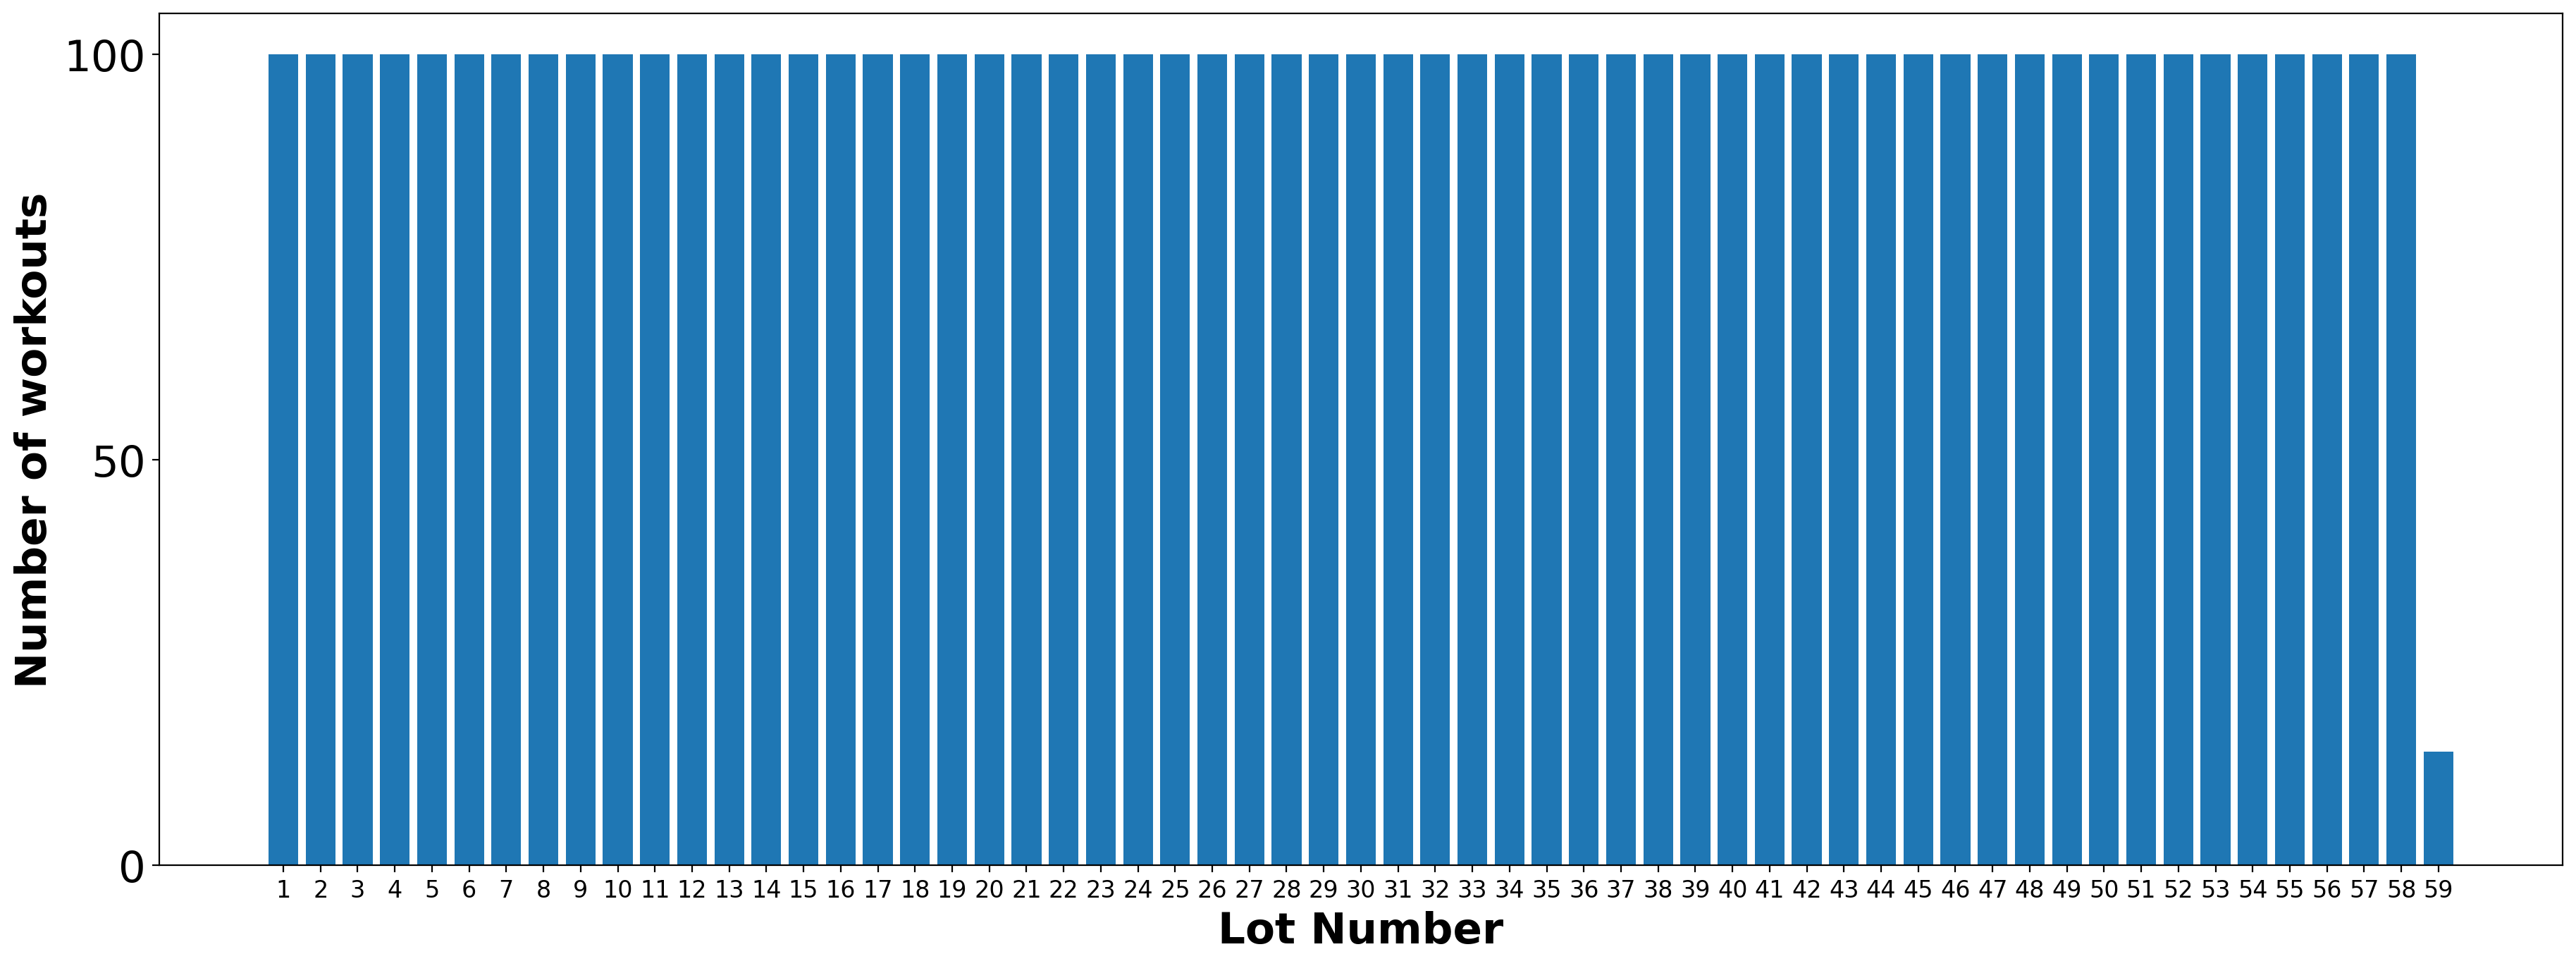

In [44]:
fig = plt.subplots(figsize =(22, 8),dpi=200)
plt.rcParams['font.size'] = 44
plt.bar(lots,[len(w) for w in workouts])
plt.xlabel('Lot Number', fontweight ='bold', fontsize = 22)
plt.ylabel('Number of workouts', fontweight ='bold', fontsize = 22)
#plt.yticks(np.arange(0,1.1,0.10),fontsize=22)
plt.yticks(fontsize=22)
plt.xticks([r for r in lots], fontsize=12)

plt.show()

In [45]:
best_cols = ['mean_rating',
 'calories',
 'r_distance',
 'd_distance_var',
 'd_distance_std',
 'r_time',
 'd_pace_mean',
 'r_pace',
 'd_time_std',
 'd_time_var',
 'd_time_sum',
 'bmi',
 'd_distance_sum',
 'weight',
 'd_pace_var',
 'o_distance']

In [46]:
# The data set used in this example is from http://archive.ics.uci.edu/ml/datasets/Wine+Quality
# P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
# Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, fbeta_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn import tree
from imblearn.combine import SMOTETomek




def get_prediction_values(cmx):
    """Gets a sklearn confusion matrix and returns the prediction values
    (FP,FN,TP,TN).

    Arguments:
    cmx {numpy.ndarray} -- [a sklearn confusion matrix]
    """

    FP = cmx.sum(axis=0) - np.diag(cmx)
    FN = cmx.sum(axis=1) - np.diag(cmx)
    TP = np.diag(cmx)
    TN = cmx.sum() - (FP + FN + TP)

    FP = FP[~np.isnan(FP)]
    FN = FN[~np.isnan(FN)]
    TP = TP[~np.isnan(TP)]
    TN = TN[~np.isnan(TN)]
    return (FP, FN, TP, TN)


def informedness_score(y_true, y_pred):
    """
    Requires "get_prediction_values"
    """
    cmx = confusion_matrix(y_true, y_pred)
    FP, FN, TP, TN = get_prediction_values(cmx)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    INF = TPR + TNR - 1
    return np.nan_to_num(INF, copy=True, nan=0.0, posinf=None, neginf=None).mean()


def eval_metrics(actual, pred):
    accuracy =     round(accuracy_score(actual, pred),3)
    precision = round(precision_score(actual, pred,average='weighted'),3)
    recall= round(recall_score(actual, pred, average='weighted'),3)
    #f1 = f1_score(actual, pred, average='weighted')
    f2 = round(fbeta_score(actual, pred, beta=2, average='weighted'),3)
    informedness = round(informedness_score(actual, pred),3)
    return accuracy, f2, recall, precision, informedness

In [47]:
from time import time, strftime, gmtime
def now():
    now = int(time()+.5)
    dt = strftime("%Y-%m-%d_%H:%M:%S", gmtime(now))
    return dt


In [48]:
now()

'2022-05-10_07:30:09'

In [49]:
lots = []
accuracys = []
f2s = []
recalls = []
precisions = []
informednesss = []
workouts = []
models = []
lens = []
rating_ranges = []

print('Run Start',now())
for lot in new_data.lot.unique():
    this_lot_data = new_data[new_data.lot<=lot]
    next_lot_data = new_data[new_data.lot==lot+1]
    if this_lot_data.shape[0]>0 and next_lot_data.shape[0]>0:
        X_train = this_lot_data[best_cols]
        y_train = this_lot_data['rating'].astype('int')
        X_test  = next_lot_data[best_cols]
        y_test  = next_lot_data['rating'].astype('int') 
        model = m.OrdinalRidge(random_state=123)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        actual = y_test
        accuracy, f2, recall, precision, informedness = eval_metrics(actual, pred)
        lots         .append(lot        )
        accuracys    .append(accuracy    )
        f2s          .append(f2          )
        recalls      .append(recall      )
        precisions   .append(precision   )
        informednesss.append(informedness)
        workouts     .append(X_test.shape[0])
        models       .append(model)
        lens         .append(X_train.shape[0])
        rating_ranges.append(len(np.unique(y_test)))

        
print('Run End',now())

lots_results = pd.DataFrame({
"lot":lots,
"model": models,                             
"accuracy":accuracys,
"f2":f2s,
"recall":recalls,
"precision":precisions,
"informedness":informednesss,
"trainig_set":lens,
"test_set":workouts})
lots_results

Run Start 2022-05-10_07:30:09
Run End 2022-05-10_07:30:09


,lot,model,accuracy,f2,recall,precision,informedness,trainig_set,test_set
0,1.0,OrdinalRidge(random_state=123),0.880,0.886,0.880,0.920,0.674,100,100
1,2.0,OrdinalRidge(random_state=123),0.910,0.909,0.910,0.913,0.876,200,100
2,3.0,OrdinalRidge(random_state=123),0.950,0.949,0.950,0.951,0.880,300,100
3,4.0,OrdinalRidge(random_state=123),0.950,0.950,0.950,0.951,0.956,400,100
4,5.0,OrdinalRidge(random_state=123),0.970,0.970,0.970,0.973,0.962,500,100
5,6.0,OrdinalRidge(random_state=123),0.950,0.950,0.950,0.953,0.948,600,100
6,7.0,OrdinalRidge(random_state=123),0.930,0.929,0.930,0.937,0.890,700,100
7,8.0,OrdinalRidge(random_state=123),0.940,0.940,0.940,0.941,0.951,800,100
8,9.0,OrdinalRidge(random_state=123),0.900,0.898,0.900,0.914,0.818,900,100
9,10.0,OrdinalRidge(random_state=123),0.920,0.920,0.920,0.919,0.879,1000,100


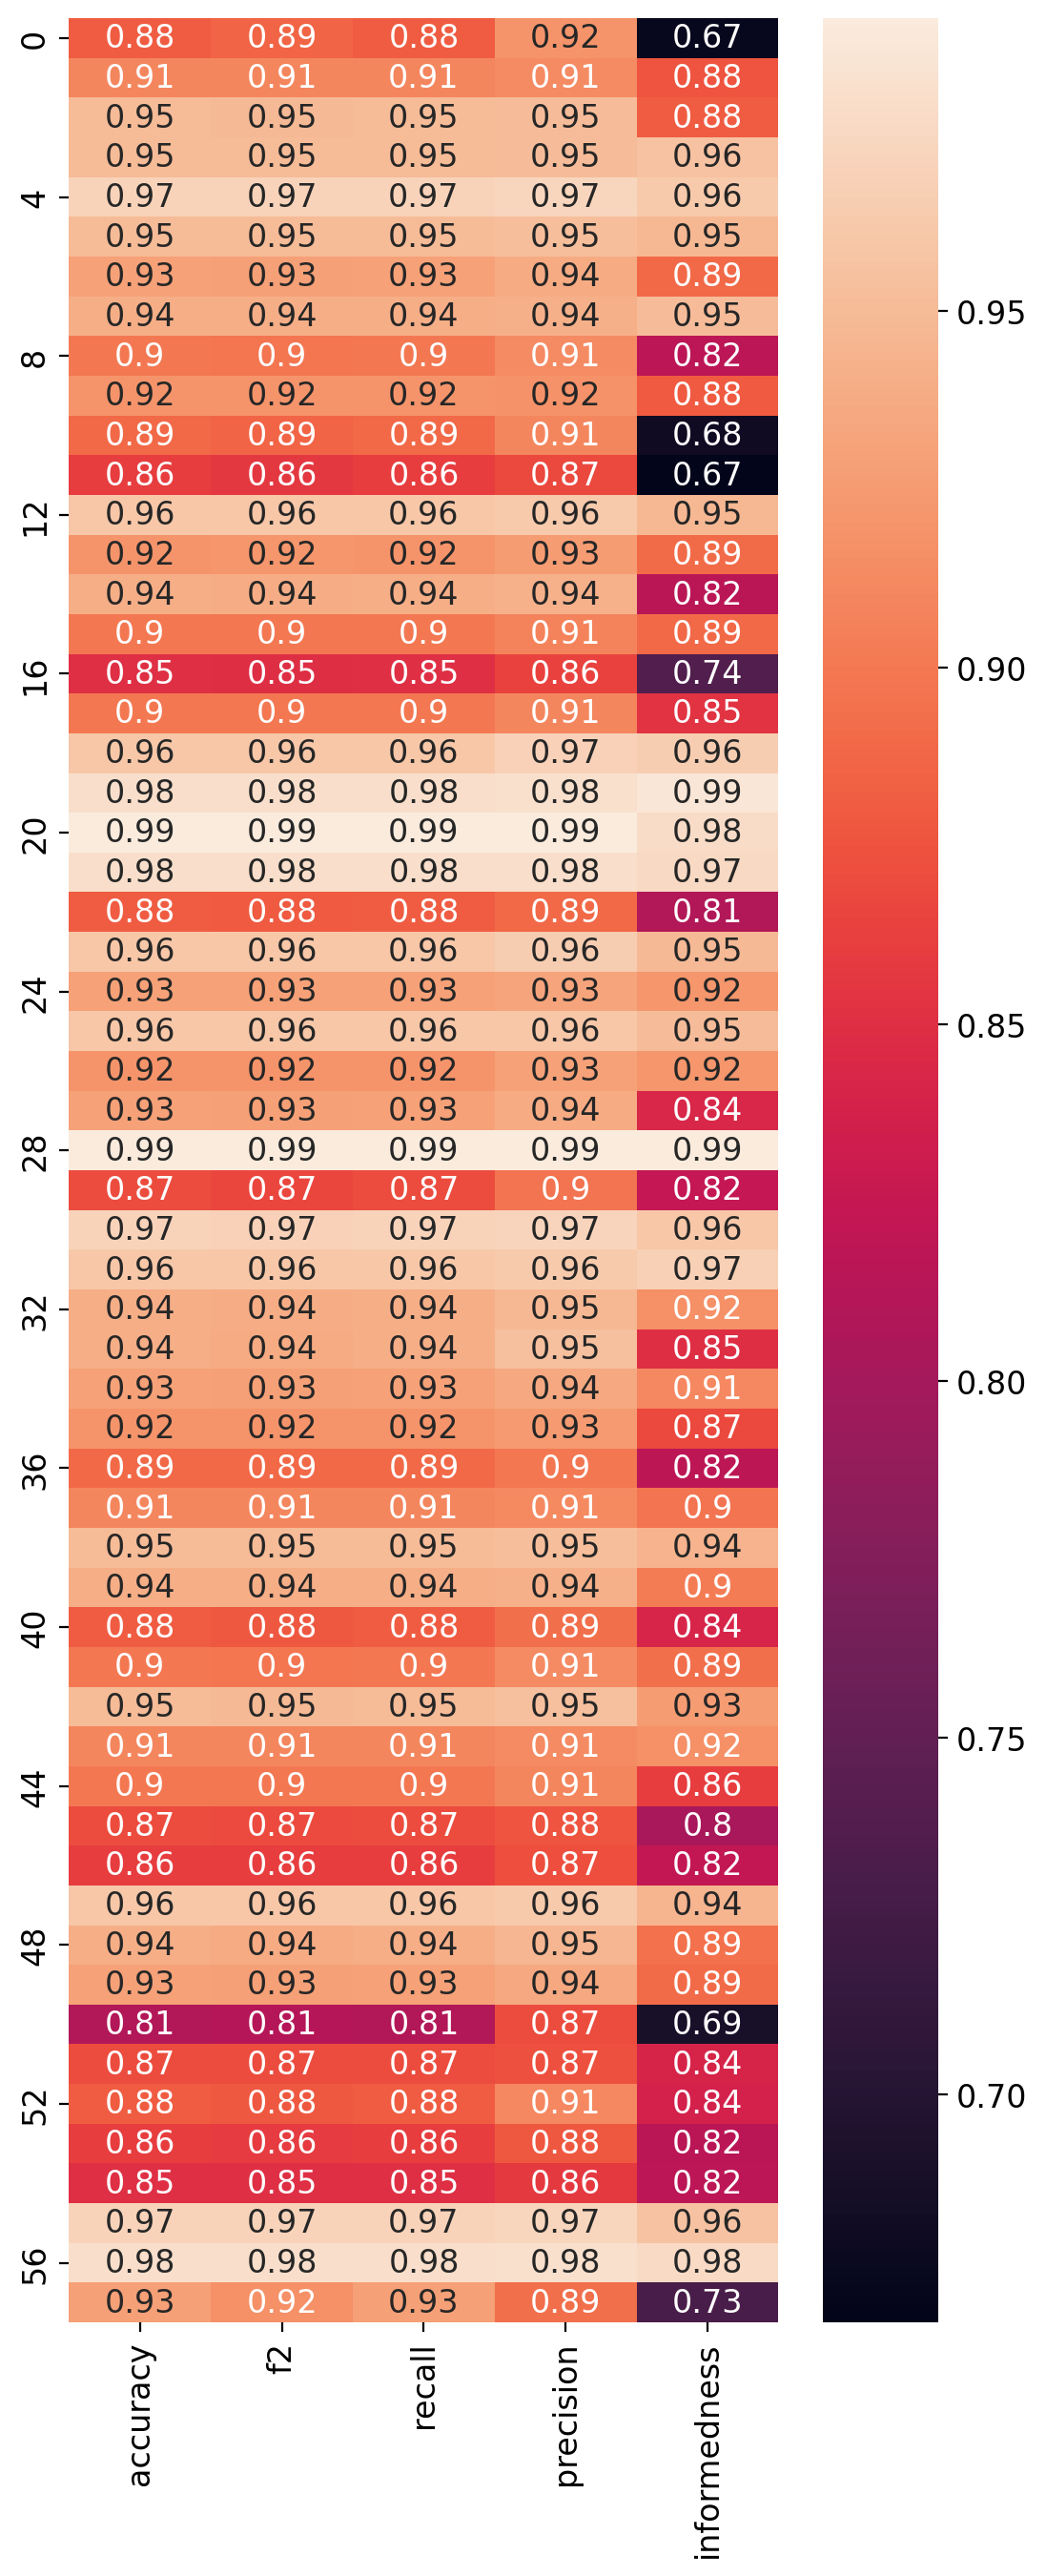

In [50]:


fig = plt.subplots(figsize =(6, 16),dpi=200)
plt.rcParams['font.size'] = 12
sns.heatmap(lots_results.drop(['lot','model','trainig_set','test_set'],axis=1), annot=True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()


In [51]:
lots_results.describe()

,lot,accuracy,f2,recall,precision,informedness,trainig_set,test_set
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,29.500000,0.921879,0.921138,0.921879,0.929190,0.877983,2950.000000,98.517241
std,16.886879,0.040970,0.041129,0.040970,0.035259,0.082286,1688.687854,11.292353
min,1.000000,0.810000,0.812000,0.810000,0.858000,0.668000,100.000000,14.000000
25%,15.250000,0.892500,0.891250,0.892500,0.909250,0.827500,1525.000000,100.000000
50%,29.500000,0.930000,0.928500,0.930000,0.933500,0.891000,2950.000000,100.000000
75%,43.750000,0.950000,0.950000,0.950000,0.954000,0.947750,4375.000000,100.000000
max,58.000000,0.990000,0.990000,0.990000,0.990000,0.991000,5800.000000,100.000000


In [52]:
pred = models[28].predict(new_data[new_data.lot>=32][best_cols])
actual = new_data[new_data.lot>=32]['rating'].astype(int)
accuracy, f2, recall, precision, informedness = eval_metrics(actual, pred)
print(accuracy, f2, recall, precision, informedness)

0.915 0.914 0.915 0.917 0.884


In [53]:
from sklearn.metrics import classification_report
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           1       0.93      0.90      0.91       240
           2       0.87      0.89      0.88       370
           3       0.90      0.86      0.88       602
           4       0.88      0.96      0.92       858
           5       1.00      0.92      0.96       644

    accuracy                           0.91      2714
   macro avg       0.92      0.91      0.91      2714
weighted avg       0.92      0.91      0.91      2714



In [54]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(actual, pred))

[[215  25   0   0   0]
 [ 15 331  24   0   0]
 [  0  25 516  61   0]
 [  0   0  31 827   0]
 [  0   0   0  51 593]]


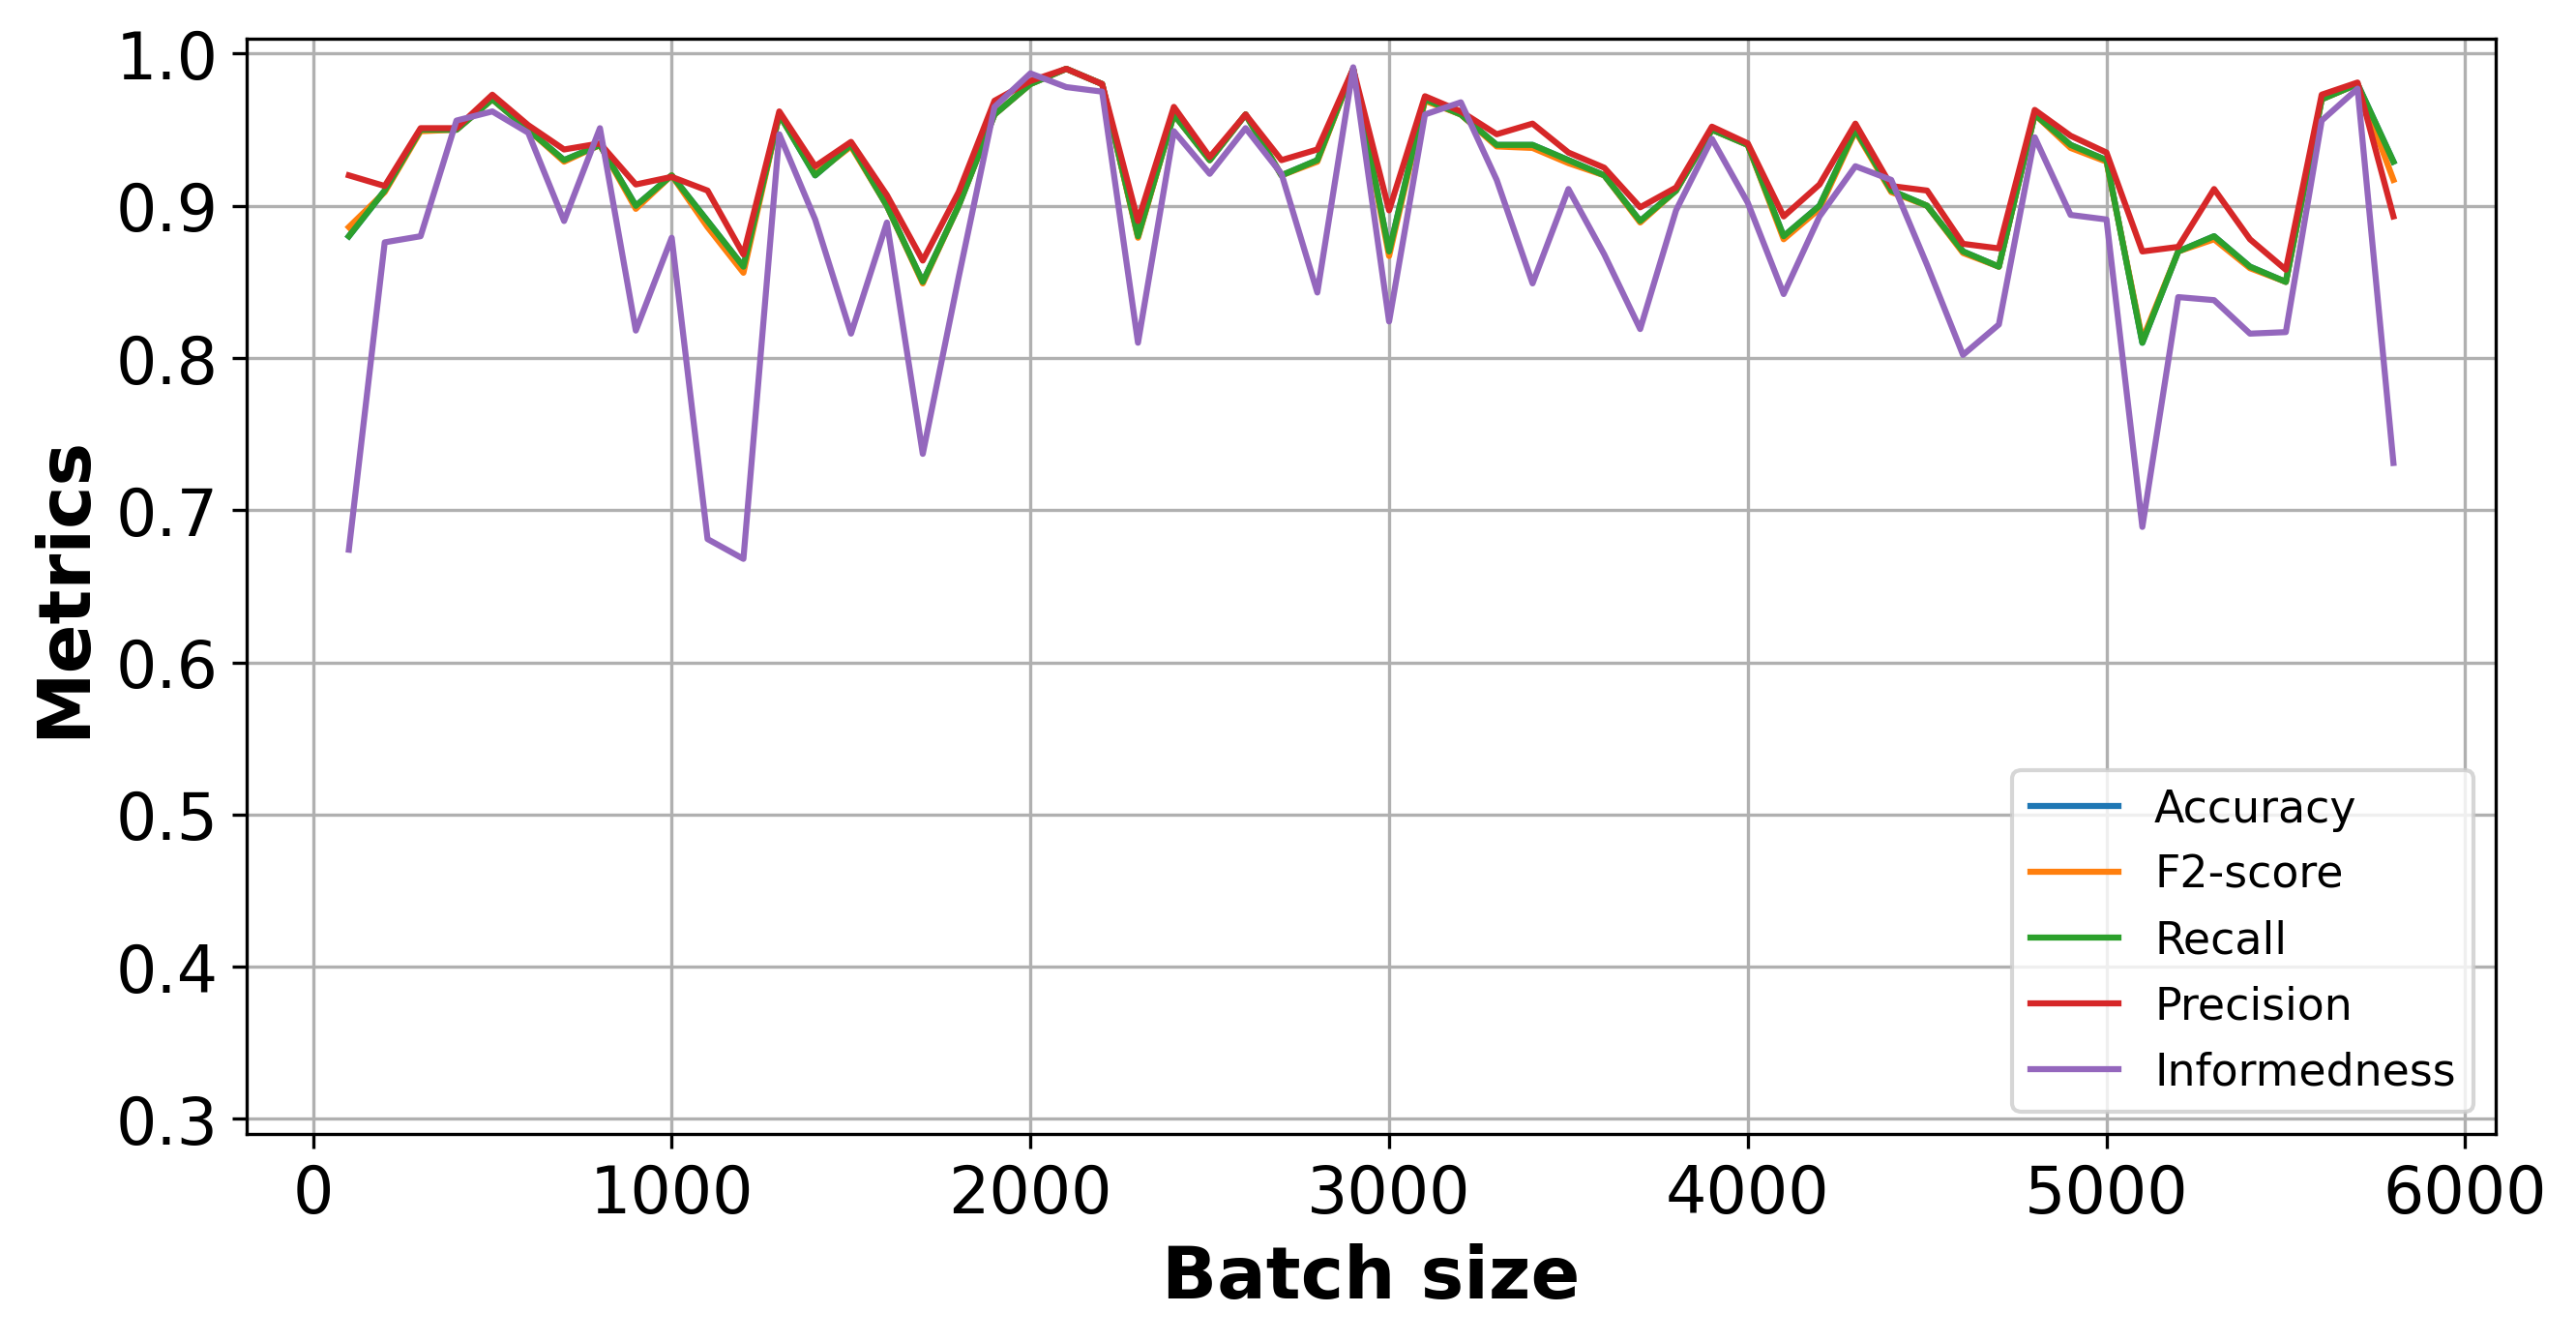

In [55]:
f, ax = plt.subplots(figsize=(10, 5),dpi=300)
ax.set(ylim=(0.29, 1.01))

#plt.plot([1]*6000)
#plt.title('DTR by rank update')
plt.plot(lots_results["trainig_set"], lots_results["accuracy"])
plt.plot(lots_results["trainig_set"], lots_results["f2"])
plt.plot(lots_results["trainig_set"], lots_results["recall"]) 
plt.plot(lots_results["trainig_set"], lots_results["precision"]) 
plt.plot(lots_results["trainig_set"], lots_results["informedness"])   
         

         

plt.xlabel('Batch size', fontweight ='bold',fontsize=18)
plt.ylabel('Metrics', fontweight ='bold',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
handles, _ = ax.get_legend_handles_labels()  
plt.grid()


plt.legend(["Accuracy", "F2-score", "Recall", "Precision", "Informedness"],loc='lower right',fontsize=18, prop={'size': 11})
plt.savefig('ordinal_metrics_over_time.pdf')

In [56]:
cols_names = {"o_pace":"Pace Objective",
"d_pace_std":"Pace Gap Standard Deviation",
"d_pace_mean":"Pace Gap",
"d_distance_var":"Distance Gap Variance",
"d_time_sum":"Temporal Gap",
"d_pace_var":"Pace Gap Variance",
"daily_load":"Daily Load",
"o_time":"Time Objective",
"r_speed":"Average Speed",
"r_distance":"Covered Distance",
"age": "User Age",
"d_distance_sum":"Distance Gap",
"r_pace":"Average Pace",
"weight":"User Weight",
"d_time_var":"Temporal Gap Variance",
"bmi":"User BMI",
"r_time":"Workout Duration",
"d_time_std":"Temporal Gap Standard Deviation",
"height":"User Height",
"o_distance":"Distance Objective",
"weekday":"Week Day",
"p_welldone":"Well-performed activities (%)",
"d_distance_std":"Distance Gap Standard Deviation",
"user_pop":"User Fidelity",
"p_running":"Running activities (%)",
"p_unknown":"Unknown activities (%)",
"p_walking":"Walking activities (%)",
"weeknumber":"Week Number",
              "month": "Month",
"progress":"Weekly Progress",
"p_has_objective":"Activities with objective (%)",
"dec_user_pop":"User Popularity Decay",
"weekly_load":"Weekly Load",
"gender":"User Gender",
 'calories':'Burnt Calories',
"days_from_previous":"Days From Previous Workout",
 'mean_rating':'Mean Rating',
              'None':'None'
             
             }

In [57]:
training_x = training_set[columns]
training_x.columns = [cols_names[x] for x in training_x.columns]
print(training_x.columns)

test_x = test_set[columns]
test_x.columns = [cols_names[x] for x in test_x.columns]
test_x.columns

Index(['Mean Rating', 'Covered Distance', 'Burnt Calories', 'Distance Gap',
       'Pace Gap', 'Distance Gap Variance', 'Distance Gap Standard Deviation',
       'Temporal Gap Standard Deviation', 'Temporal Gap',
       'Temporal Gap Variance', 'Workout Duration', 'Average Pace',
       'Pace Gap Variance', 'Pace Gap Standard Deviation', 'Pace Objective',
       'Time Objective', 'User BMI', 'Distance Objective',
       'Well-performed activities (%)', 'Week Number',
       'Running activities (%)', 'User Weight', 'User Fidelity',
       'Activities with objective (%)', 'User Age', 'User Height', 'Week Day',
       'Walking activities (%)', 'Month', 'Days From Previous Workout'],
      dtype='object')


Index(['Mean Rating', 'Covered Distance', 'Burnt Calories', 'Distance Gap',
       'Pace Gap', 'Distance Gap Variance', 'Distance Gap Standard Deviation',
       'Temporal Gap Standard Deviation', 'Temporal Gap',
       'Temporal Gap Variance', 'Workout Duration', 'Average Pace',
       'Pace Gap Variance', 'Pace Gap Standard Deviation', 'Pace Objective',
       'Time Objective', 'User BMI', 'Distance Objective',
       'Well-performed activities (%)', 'Week Number',
       'Running activities (%)', 'User Weight', 'User Fidelity',
       'Activities with objective (%)', 'User Age', 'User Height', 'Week Day',
       'Walking activities (%)', 'Month', 'Days From Previous Workout'],
      dtype='object')

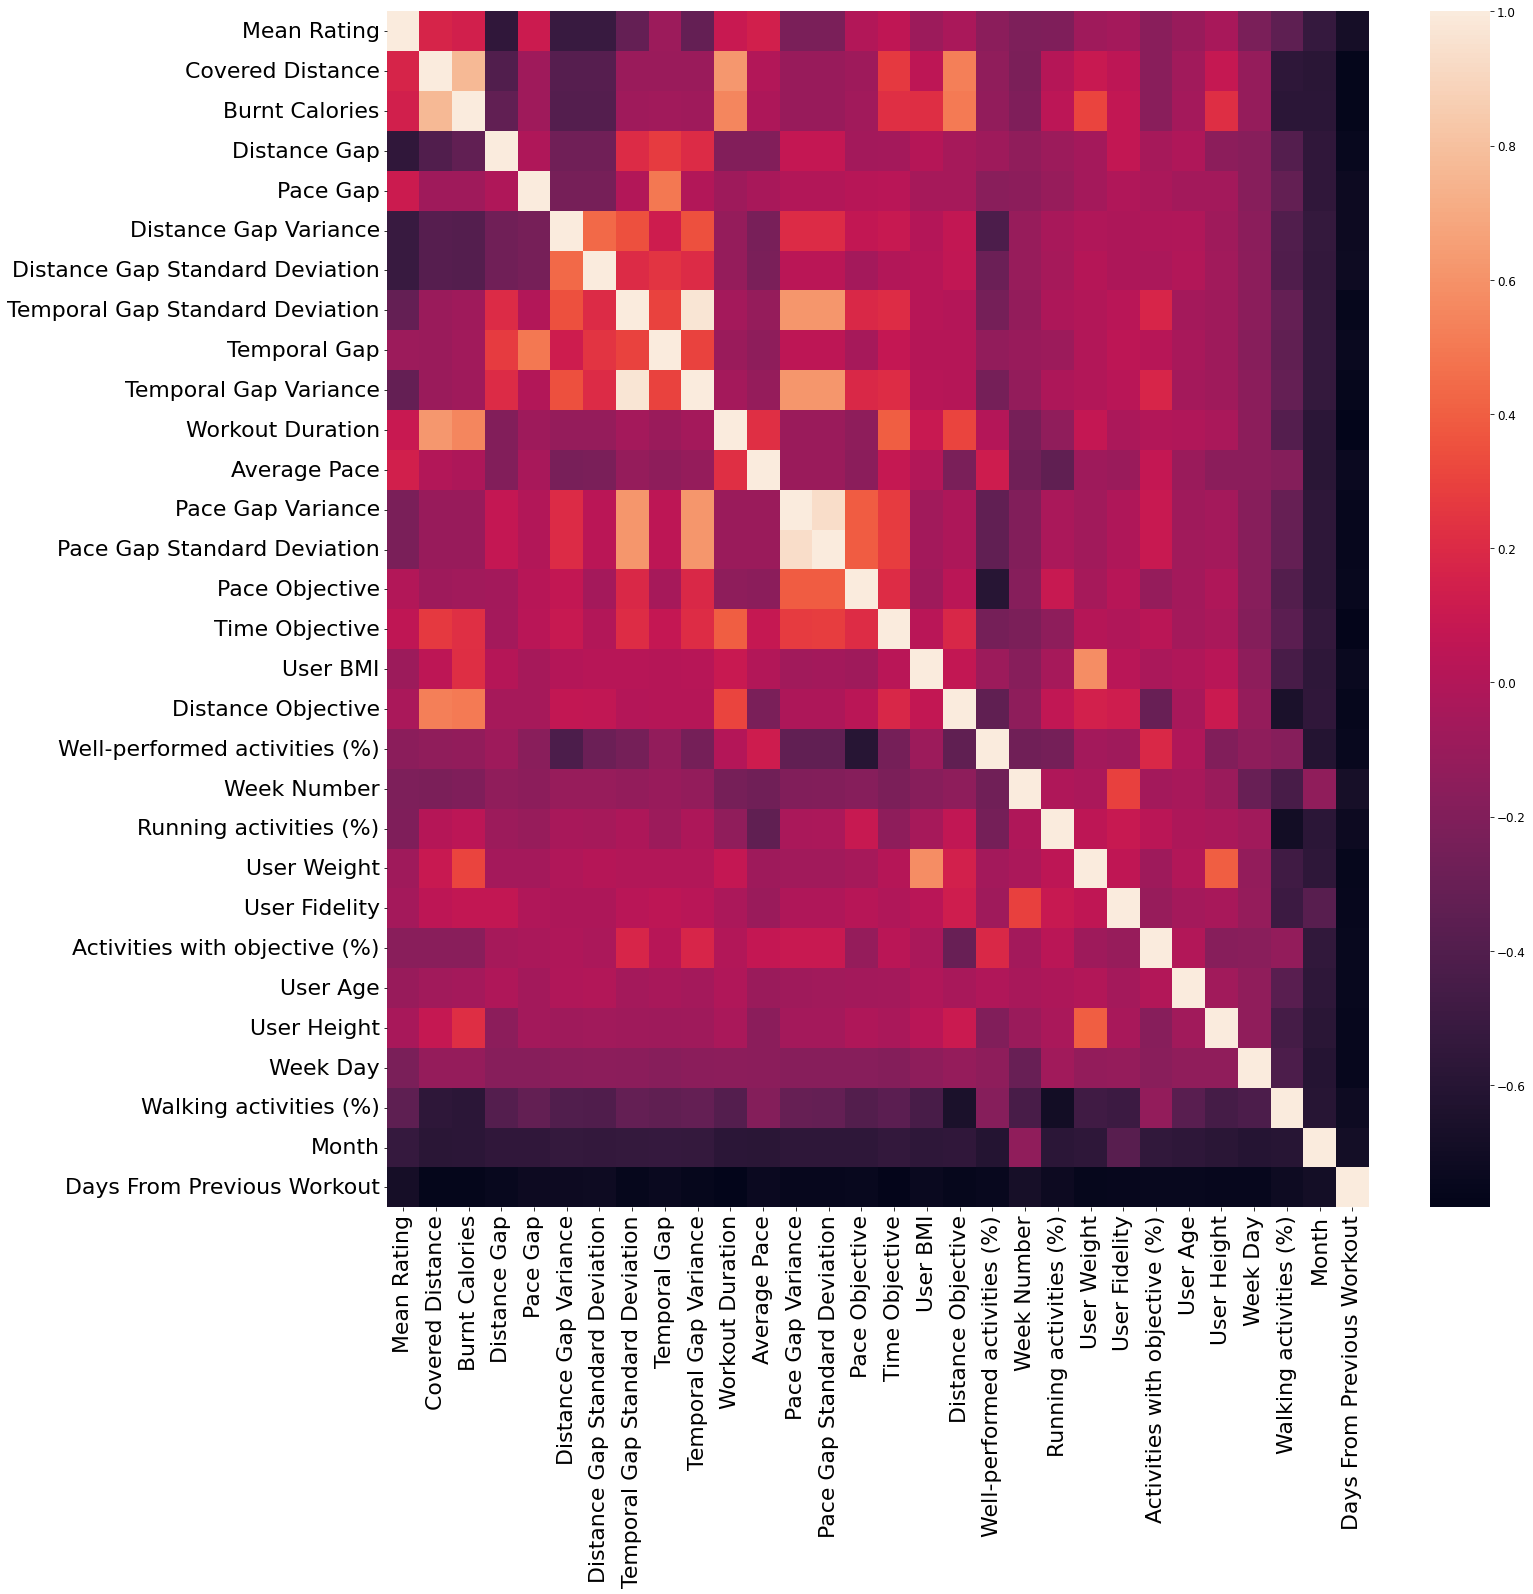

In [58]:
# creating set to hold the correlated features
corr_features = set()
Xtrain = training_set[columns]
Xtrain.columns =  [cols_names[x] for x in training_set[columns].columns]
# create the correlation matrix (default to pearson)
corr_matrix = Xtrain.corr(method='kendall')



# optional: display a heatmap of the correlation matrix
plt.figure(figsize=(22,22))
sns.heatmap(corr_matrix)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
for i in range(len(corr_matrix .columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)

In [59]:
model = m.OrdinalRidge()
model.fit(training_x.drop(labels=corr_features, axis=1),training_set.rating.values)

OrdinalRidge()

In [60]:
model = ensemble.RandomForestClassifier()
model.fit(training_x.drop(labels=corr_features, axis=1),training_set.rating.values)

RandomForestClassifier()

In [61]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# perform permutation importance
results = permutation_importance(model, training_x.drop(labels=corr_features, axis=1),training_set.rating.values.astype(int), scoring=make_scorer(informedness_score, greater_is_better=True))
# get importance
importance = results.importances_mean

In [62]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# define feature selection
fs = SelectKBest(score_func=f_classif, k=10)
# apply feature selection
X_selected = fs.fit_transform(training_x,training_set.rating.values.astype(int))
X_selected.shape

(5532, 10)

In [63]:
features_importance = pd.DataFrame({'feature':training_x.columns,'importance': abs(fs.scores_)})
features_importance.sort_values('importance', ascending=[False])
important_features = features_importance[features_importance['importance']>0]
important_features = important_features.sort_values('importance', ascending=[True])

In [64]:
important_features

,feature,importance
11,Average Pace,0.736619
14,Pace Objective,1.279276
17,Distance Objective,4.203568
12,Pace Gap Variance,4.363119
4,Pace Gap,4.397974
9,Temporal Gap Variance,6.015603
27,Walking activities (%),8.566853
13,Pace Gap Standard Deviation,8.662964
25,User Height,8.895888
21,User Weight,11.451233


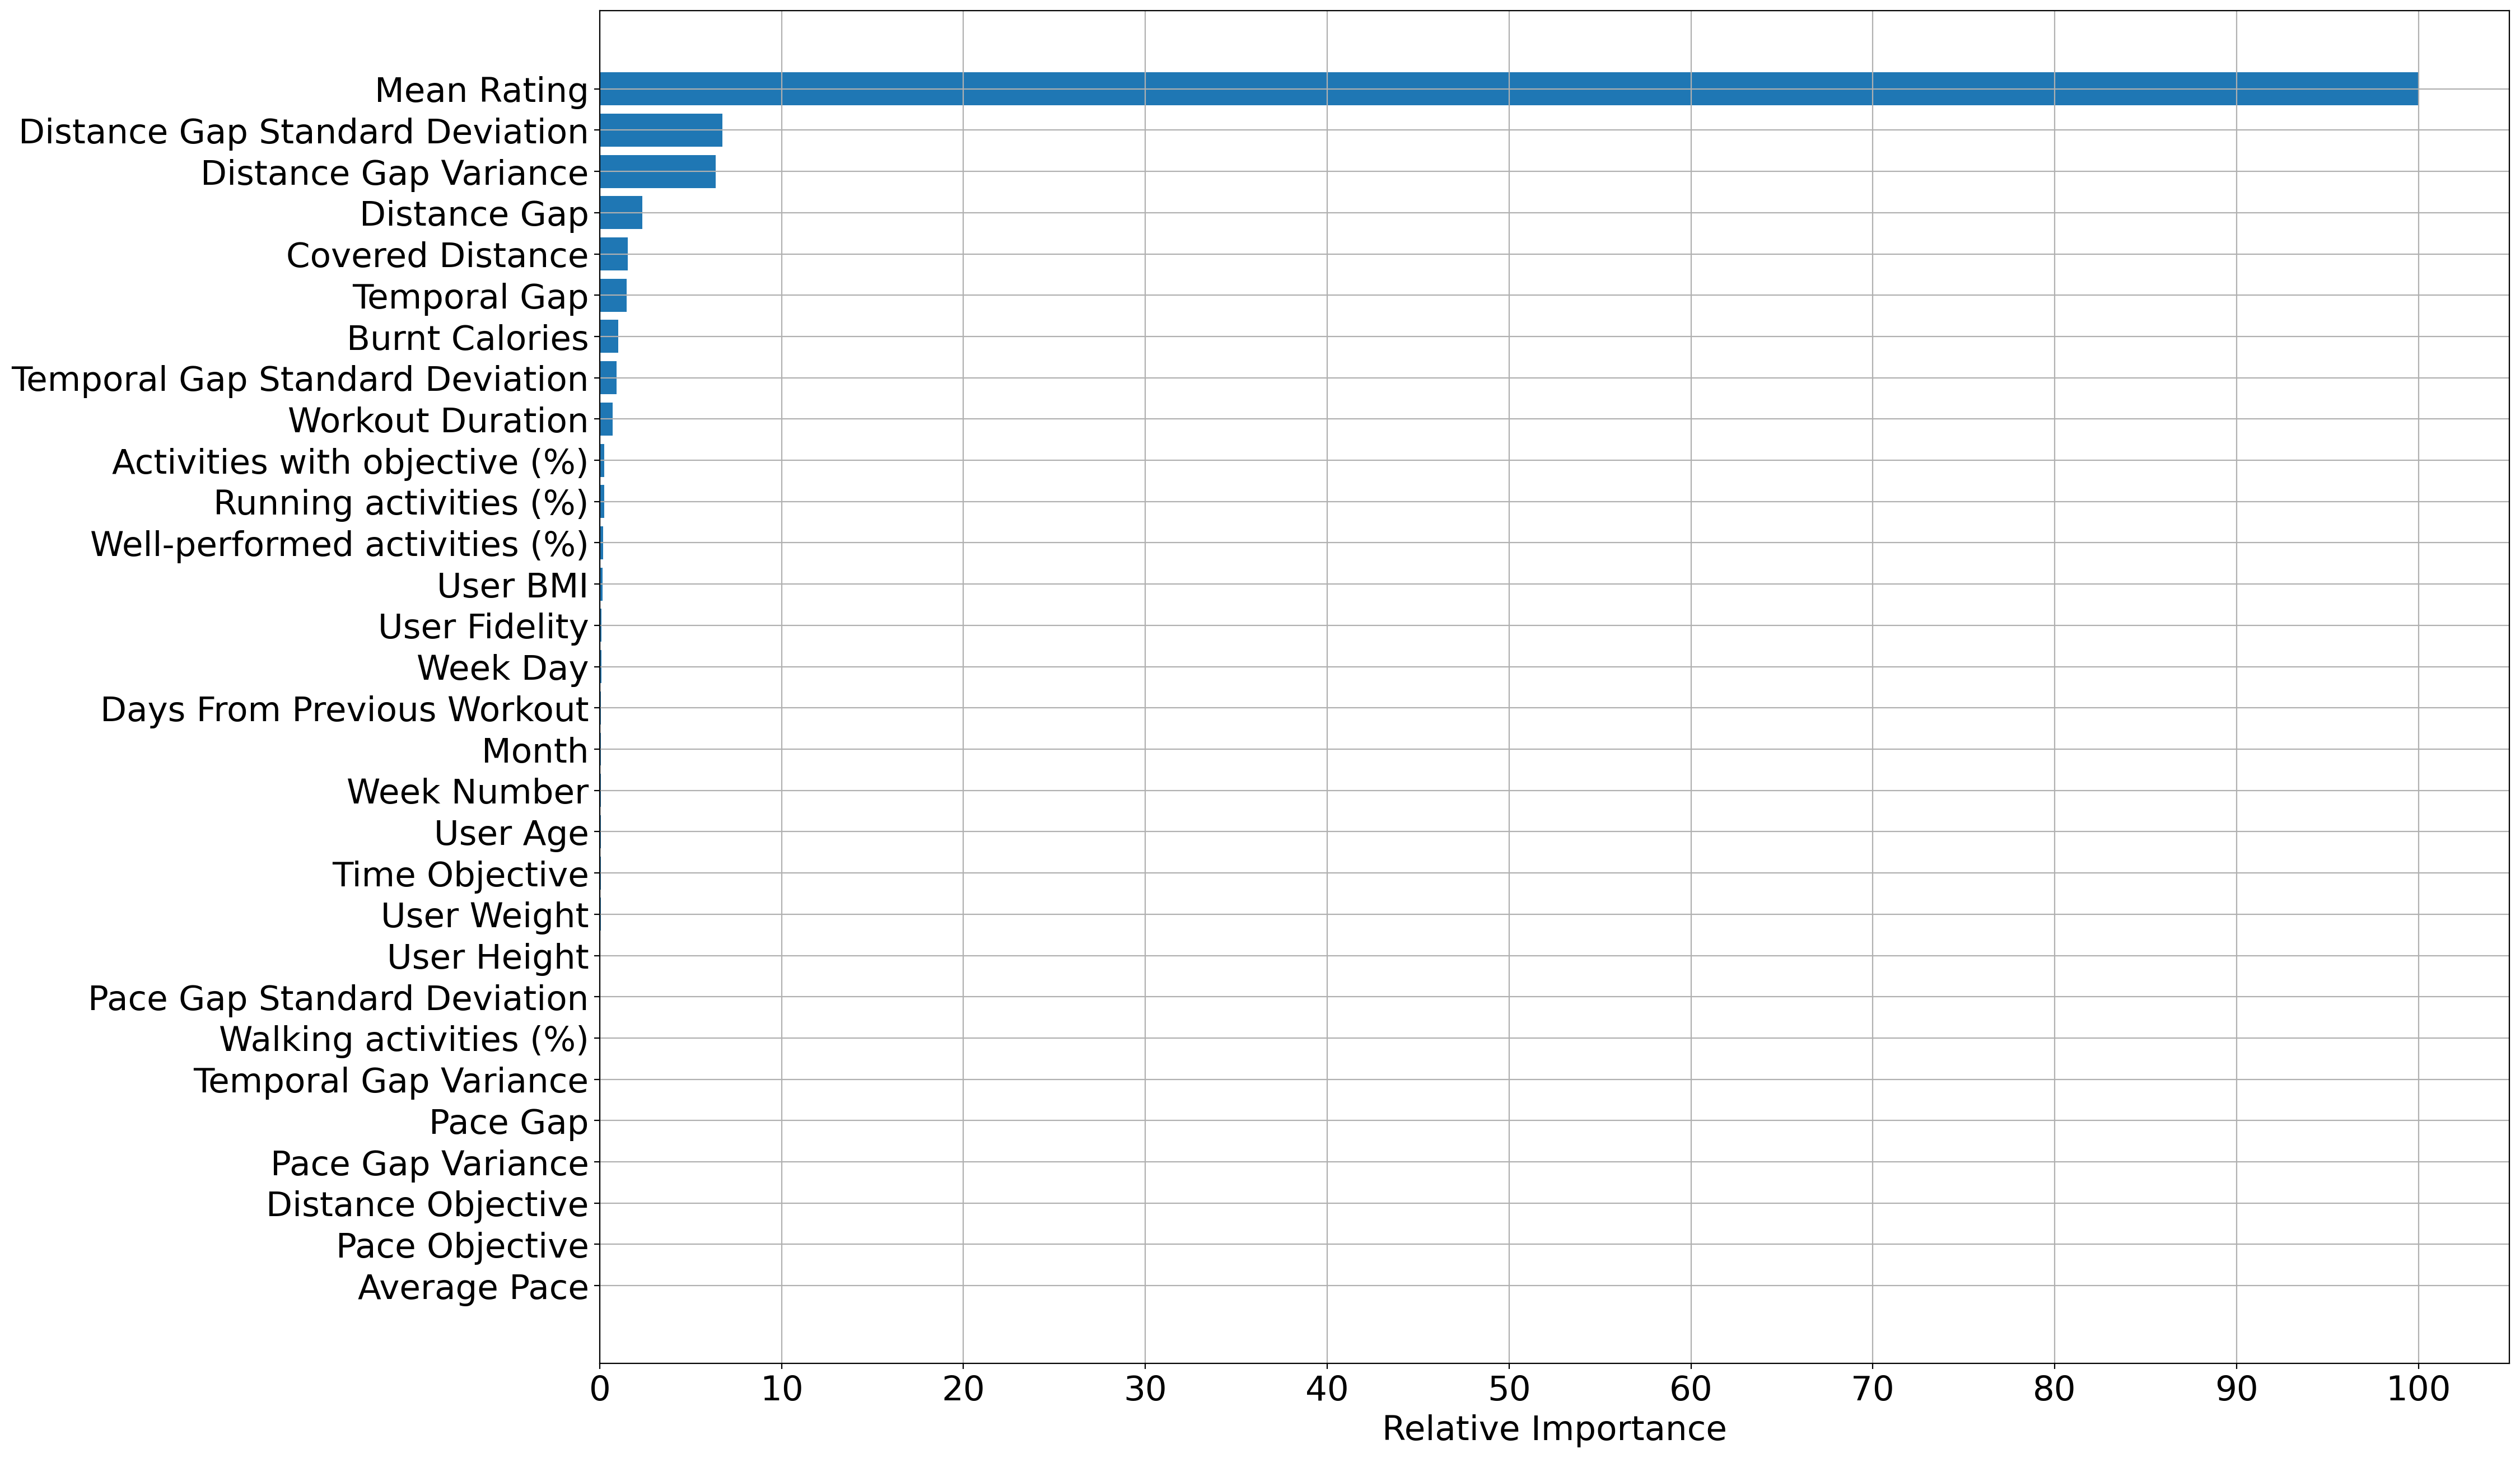

In [65]:
features = important_features['feature']
importances = important_features['importance']
sorted_idx = importances.index
importances = 100.0 * (importances )/ importances.max()



pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(22,16), dpi=200)
plt.barh(pos, importances[sorted_idx], align='center')
plt.yticks(pos, features, fontsize=22)
#plt.xticks(np.arange(0,110,10),fontsize=22)
plt.xlabel('Relative Importance', fontsize=22)
plt.xticks(np.arange(0,110,10),fontsize=22)
plt.title('')
plt.grid()
plt.show()

In [66]:
ordinal_ablation_results = []
features_cp = list(features.copy())
i = 0
for feature in features:
    if len(features_cp)>1:
        i=i+1
        model = m.OrdinalRidge()
        features_cp.remove(feature)
        model.fit(training_x[features_cp],training_set.rating.values-1)
        pred = model.predict(test_x[features_cp]).astype(int)
        actual = test_set.rating.values-1
        accuracy, f2, recall, precision, informedness = eval_metrics(actual.astype(int), pred.astype(int))
        ordinal_ablation_results.append([accuracy, f2, recall, precision, informedness])
        print(str(i)+' & '+ str(round(accuracy,3))+' & '+ str(round(f2,3))+' & '+ str(round(recall,3))+' & '+ str(round(precision,3))+' & '+ str(round(informedness,3)),features_cp)

1 & 0.924 & 0.924 & 0.924 & 0.926 & 0.899 ['Pace Objective', 'Distance Objective', 'Pace Gap Variance', 'Pace Gap', 'Temporal Gap Variance', 'Walking activities (%)', 'Pace Gap Standard Deviation', 'User Height', 'User Weight', 'Time Objective', 'User Age', 'Week Number', 'Month', 'Days From Previous Workout', 'Week Day', 'User Fidelity', 'User BMI', 'Well-performed activities (%)', 'Running activities (%)', 'Activities with objective (%)', 'Workout Duration', 'Temporal Gap Standard Deviation', 'Burnt Calories', 'Temporal Gap', 'Covered Distance', 'Distance Gap', 'Distance Gap Variance', 'Distance Gap Standard Deviation', 'Mean Rating']
2 & 0.921 & 0.921 & 0.921 & 0.923 & 0.895 ['Distance Objective', 'Pace Gap Variance', 'Pace Gap', 'Temporal Gap Variance', 'Walking activities (%)', 'Pace Gap Standard Deviation', 'User Height', 'User Weight', 'Time Objective', 'User Age', 'Week Number', 'Month', 'Days From Previous Workout', 'Week Day', 'User Fidelity', 'User BMI', 'Well-performed acti

28 & 0.928 & 0.927 & 0.928 & 0.93 & 0.904 ['Distance Gap Standard Deviation', 'Mean Rating']
29 & 0.914 & 0.913 & 0.914 & 0.919 & 0.885 ['Mean Rating']


In [67]:
ordinal_ablation_df = pd.DataFrame(ordinal_ablation_results, columns=['Accuracy', 'F2-Score', 'Recall', 'Precision', 'Informedness'])
ordinal_ablation_df

,Accuracy,F2-Score,Recall,Precision,Informedness
0,0.924,0.924,0.924,0.926,0.899
1,0.921,0.921,0.921,0.923,0.895
2,0.921,0.921,0.921,0.923,0.895
3,0.924,0.924,0.924,0.927,0.900
4,0.924,0.924,0.924,0.927,0.900
5,0.928,0.928,0.928,0.930,0.903
6,0.924,0.924,0.924,0.928,0.897
7,0.928,0.928,0.928,0.930,0.903
8,0.928,0.928,0.928,0.930,0.903
9,0.928,0.928,0.928,0.930,0.903


In [68]:
ordinal_ablation_df.describe()

,Accuracy,F2-Score,Recall,Precision,Informedness
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.923966,0.923828,0.923966,0.926897,0.898138
std,0.003407,0.003402,0.003407,0.003016,0.004389
min,0.914000,0.913000,0.914000,0.919000,0.885000
25%,0.921000,0.921000,0.921000,0.924000,0.895000
50%,0.924000,0.924000,0.924000,0.928000,0.898000
75%,0.928000,0.927000,0.928000,0.930000,0.903000
max,0.928000,0.928000,0.928000,0.931000,0.904000


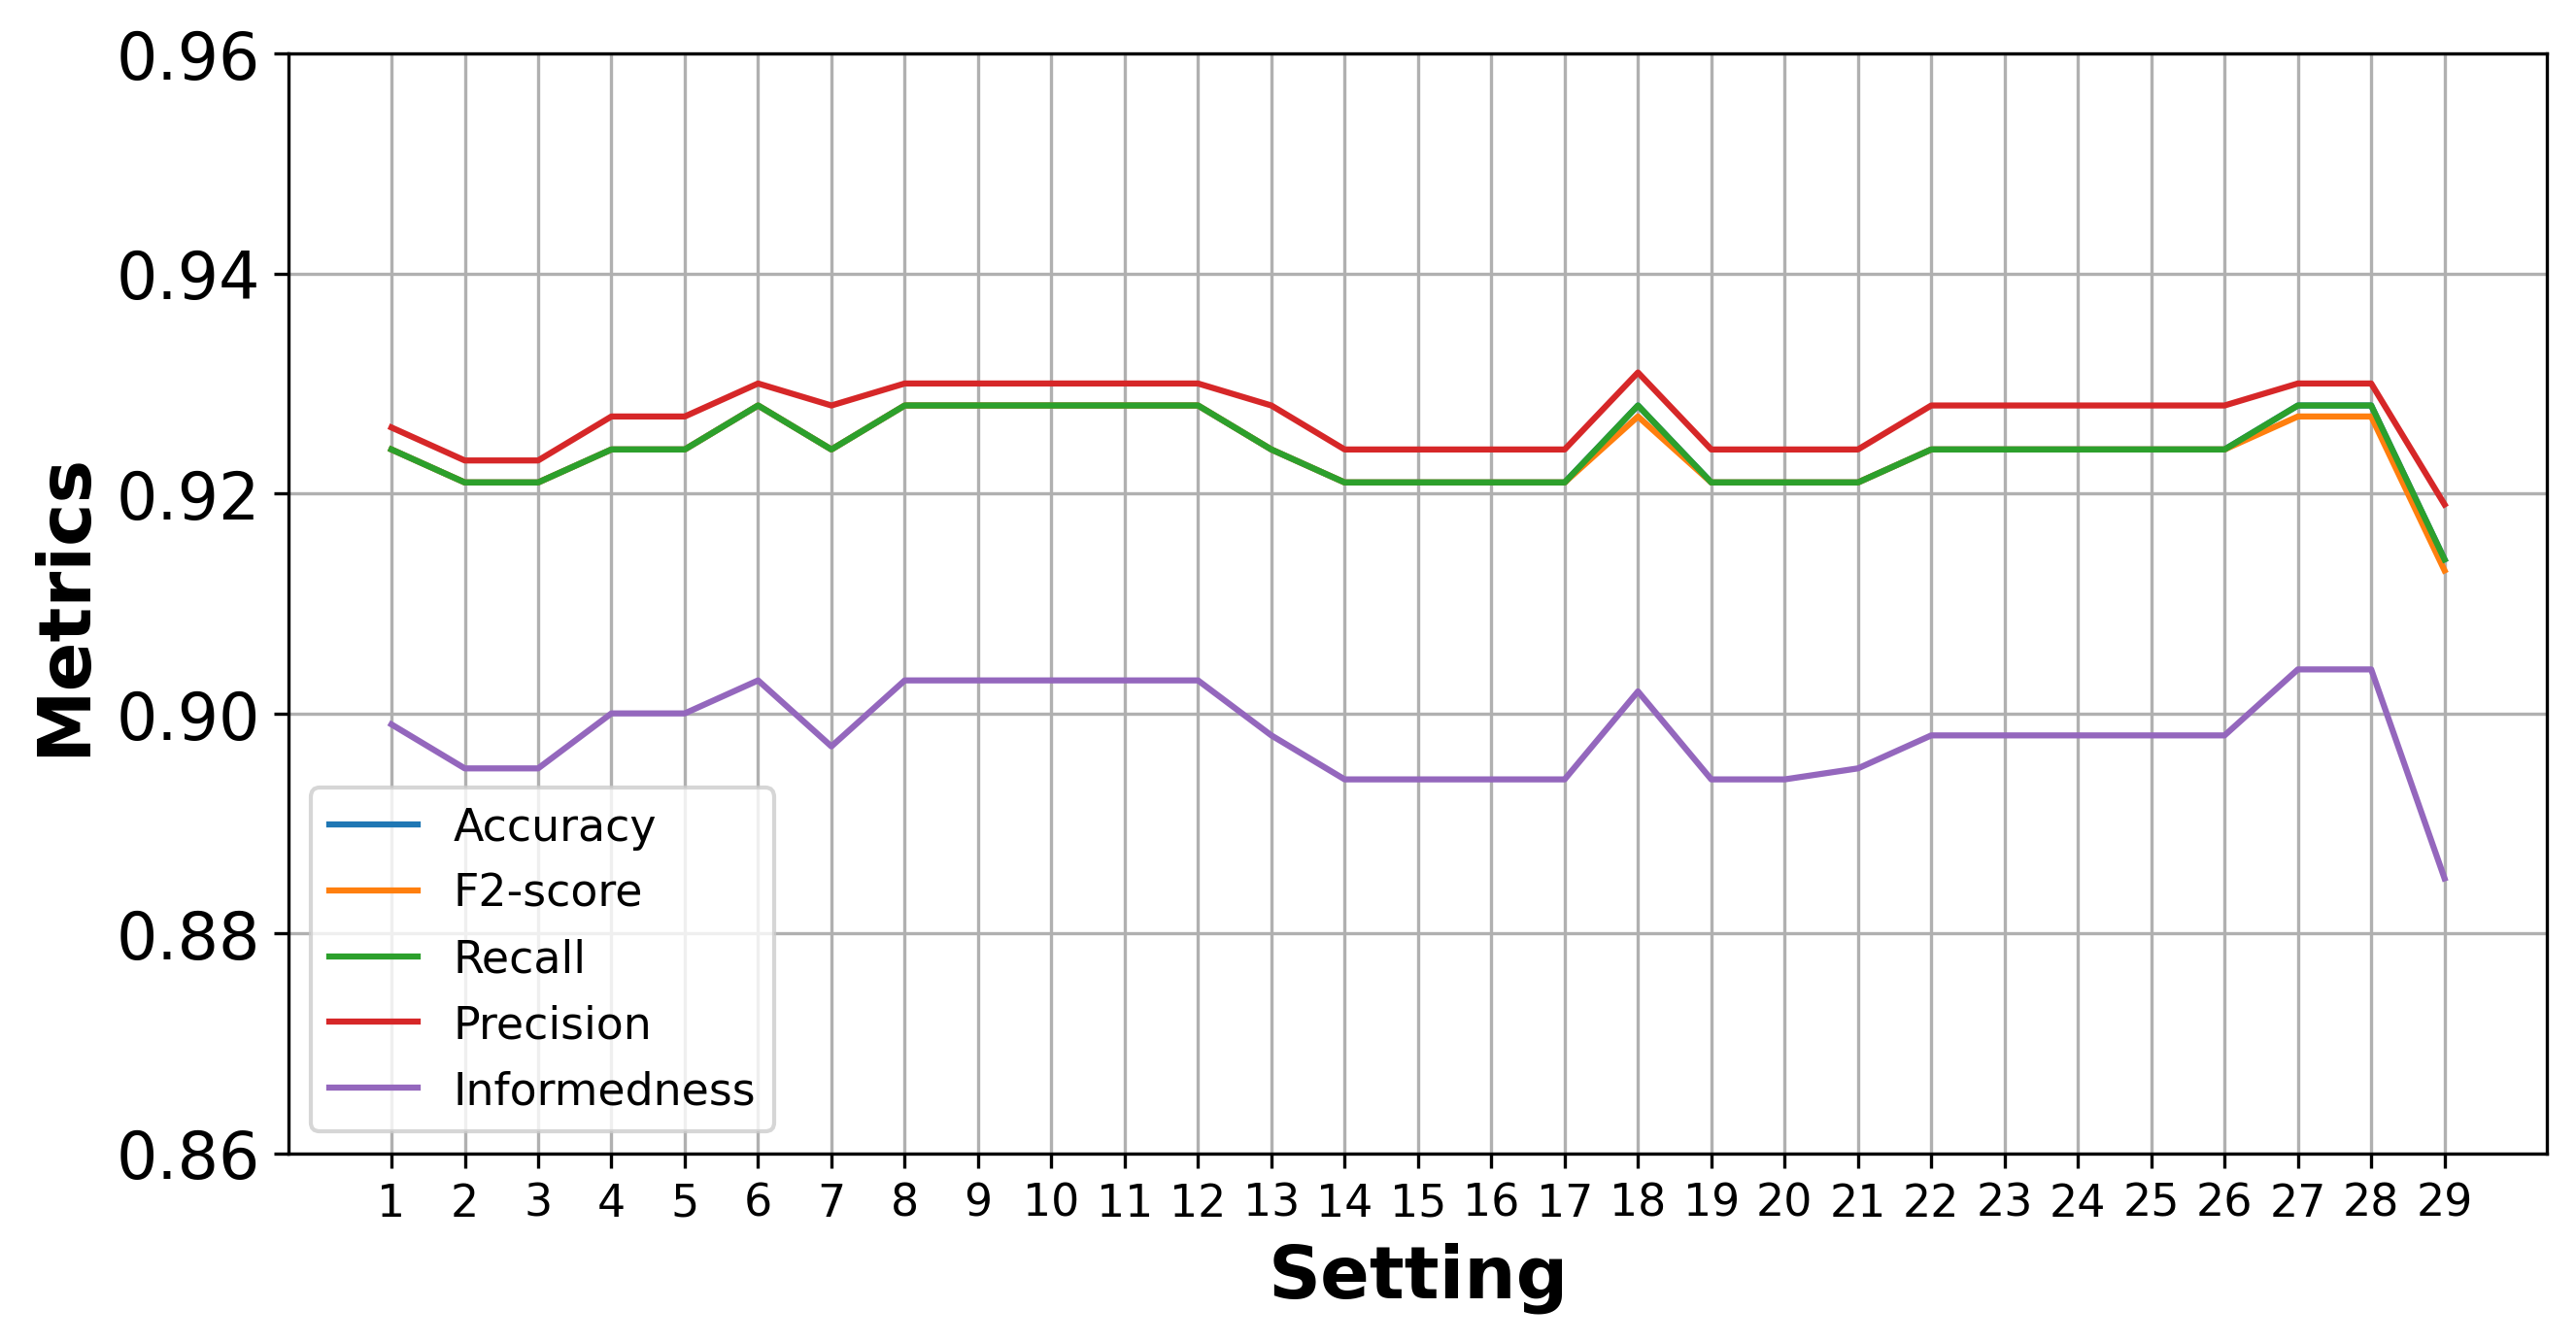

In [69]:
f, ax = plt.subplots(figsize=(10, 5),dpi=300)
ax.set(ylim=(0.86, 0.96))

#plt.plot([1]*6000)
#plt.title('DTR by rank update')
plt.plot(ordinal_ablation_df.index+1, ordinal_ablation_df["Accuracy"])
plt.plot(ordinal_ablation_df.index+1, ordinal_ablation_df["F2-Score"])
plt.plot(ordinal_ablation_df.index+1, ordinal_ablation_df["Recall"])
plt.plot(ordinal_ablation_df.index+1, ordinal_ablation_df["Precision"])
plt.plot(ordinal_ablation_df.index+1, ordinal_ablation_df["Informedness"])
         

plt.xlabel('Setting', fontweight ='bold',fontsize=18)
plt.ylabel('Metrics', fontweight ='bold',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(ordinal_ablation_df.index+1,fontsize=11)
handles, _ = ax.get_legend_handles_labels()          
plt.grid()
plt.legend(["Accuracy", "F2-score", "Recall", "Precision", "Informedness"],loc='lower left',fontsize=18, prop={'size': 11})
plt.savefig('ordinal_ablation_study.pdf')

In [70]:
multiclass_ablation_results = []
features_cp = list(features)
i = 0
for feature in features:
    if len(features_cp)>1:
        i=i+1
        model = ensemble.RandomForestClassifier()
        features_cp.remove(feature)
        model.fit(training_x[features_cp],training_set.rating.values-1)
        pred = model.predict(test_x[features_cp]).astype(int)
        actual = test_set.rating.values-1
        accuracy, f2, recall, precision, informedness = eval_metrics(actual.astype(int), pred.astype(int))
        multiclass_ablation_results.append([accuracy, f2, recall, precision, informedness])
        print(str(i)+' & '+ str(round(accuracy,3))+' & '+ str(round(f2,3))+' & '+ str(round(recall,3))+' & '+ str(round(precision,3))+' & '+ str(round(informedness,3)),features_cp)

1 & 0.941 & 0.941 & 0.941 & 0.944 & 0.927 ['Pace Objective', 'Distance Objective', 'Pace Gap Variance', 'Pace Gap', 'Temporal Gap Variance', 'Walking activities (%)', 'Pace Gap Standard Deviation', 'User Height', 'User Weight', 'Time Objective', 'User Age', 'Week Number', 'Month', 'Days From Previous Workout', 'Week Day', 'User Fidelity', 'User BMI', 'Well-performed activities (%)', 'Running activities (%)', 'Activities with objective (%)', 'Workout Duration', 'Temporal Gap Standard Deviation', 'Burnt Calories', 'Temporal Gap', 'Covered Distance', 'Distance Gap', 'Distance Gap Variance', 'Distance Gap Standard Deviation', 'Mean Rating']
2 & 0.917 & 0.917 & 0.917 & 0.92 & 0.894 ['Distance Objective', 'Pace Gap Variance', 'Pace Gap', 'Temporal Gap Variance', 'Walking activities (%)', 'Pace Gap Standard Deviation', 'User Height', 'User Weight', 'Time Objective', 'User Age', 'Week Number', 'Month', 'Days From Previous Workout', 'Week Day', 'User Fidelity', 'User BMI', 'Well-performed activ

18 & 0.938 & 0.938 & 0.938 & 0.941 & 0.922 ['Well-performed activities (%)', 'Running activities (%)', 'Activities with objective (%)', 'Workout Duration', 'Temporal Gap Standard Deviation', 'Burnt Calories', 'Temporal Gap', 'Covered Distance', 'Distance Gap', 'Distance Gap Variance', 'Distance Gap Standard Deviation', 'Mean Rating']
19 & 0.941 & 0.941 & 0.941 & 0.944 & 0.928 ['Running activities (%)', 'Activities with objective (%)', 'Workout Duration', 'Temporal Gap Standard Deviation', 'Burnt Calories', 'Temporal Gap', 'Covered Distance', 'Distance Gap', 'Distance Gap Variance', 'Distance Gap Standard Deviation', 'Mean Rating']
20 & 0.938 & 0.938 & 0.938 & 0.941 & 0.923 ['Activities with objective (%)', 'Workout Duration', 'Temporal Gap Standard Deviation', 'Burnt Calories', 'Temporal Gap', 'Covered Distance', 'Distance Gap', 'Distance Gap Variance', 'Distance Gap Standard Deviation', 'Mean Rating']
21 & 0.945 & 0.945 & 0.945 & 0.947 & 0.932 ['Workout Duration', 'Temporal Gap Standa

In [71]:
multiclass_ablation_df = pd.DataFrame(multiclass_ablation_results, columns=['Accuracy', 'F2-Score', 'Recall', 'Precision', 'Informedness'])
multiclass_ablation_df

,Accuracy,F2-Score,Recall,Precision,Informedness
0,0.941,0.941,0.941,0.944,0.927
1,0.917,0.917,0.917,0.920,0.894
2,0.931,0.931,0.931,0.934,0.912
3,0.928,0.927,0.928,0.930,0.907
4,0.934,0.934,0.934,0.937,0.916
5,0.931,0.931,0.931,0.933,0.912
6,0.931,0.931,0.931,0.934,0.911
7,0.921,0.921,0.921,0.924,0.900
8,0.934,0.935,0.934,0.936,0.919
9,0.928,0.928,0.928,0.930,0.908


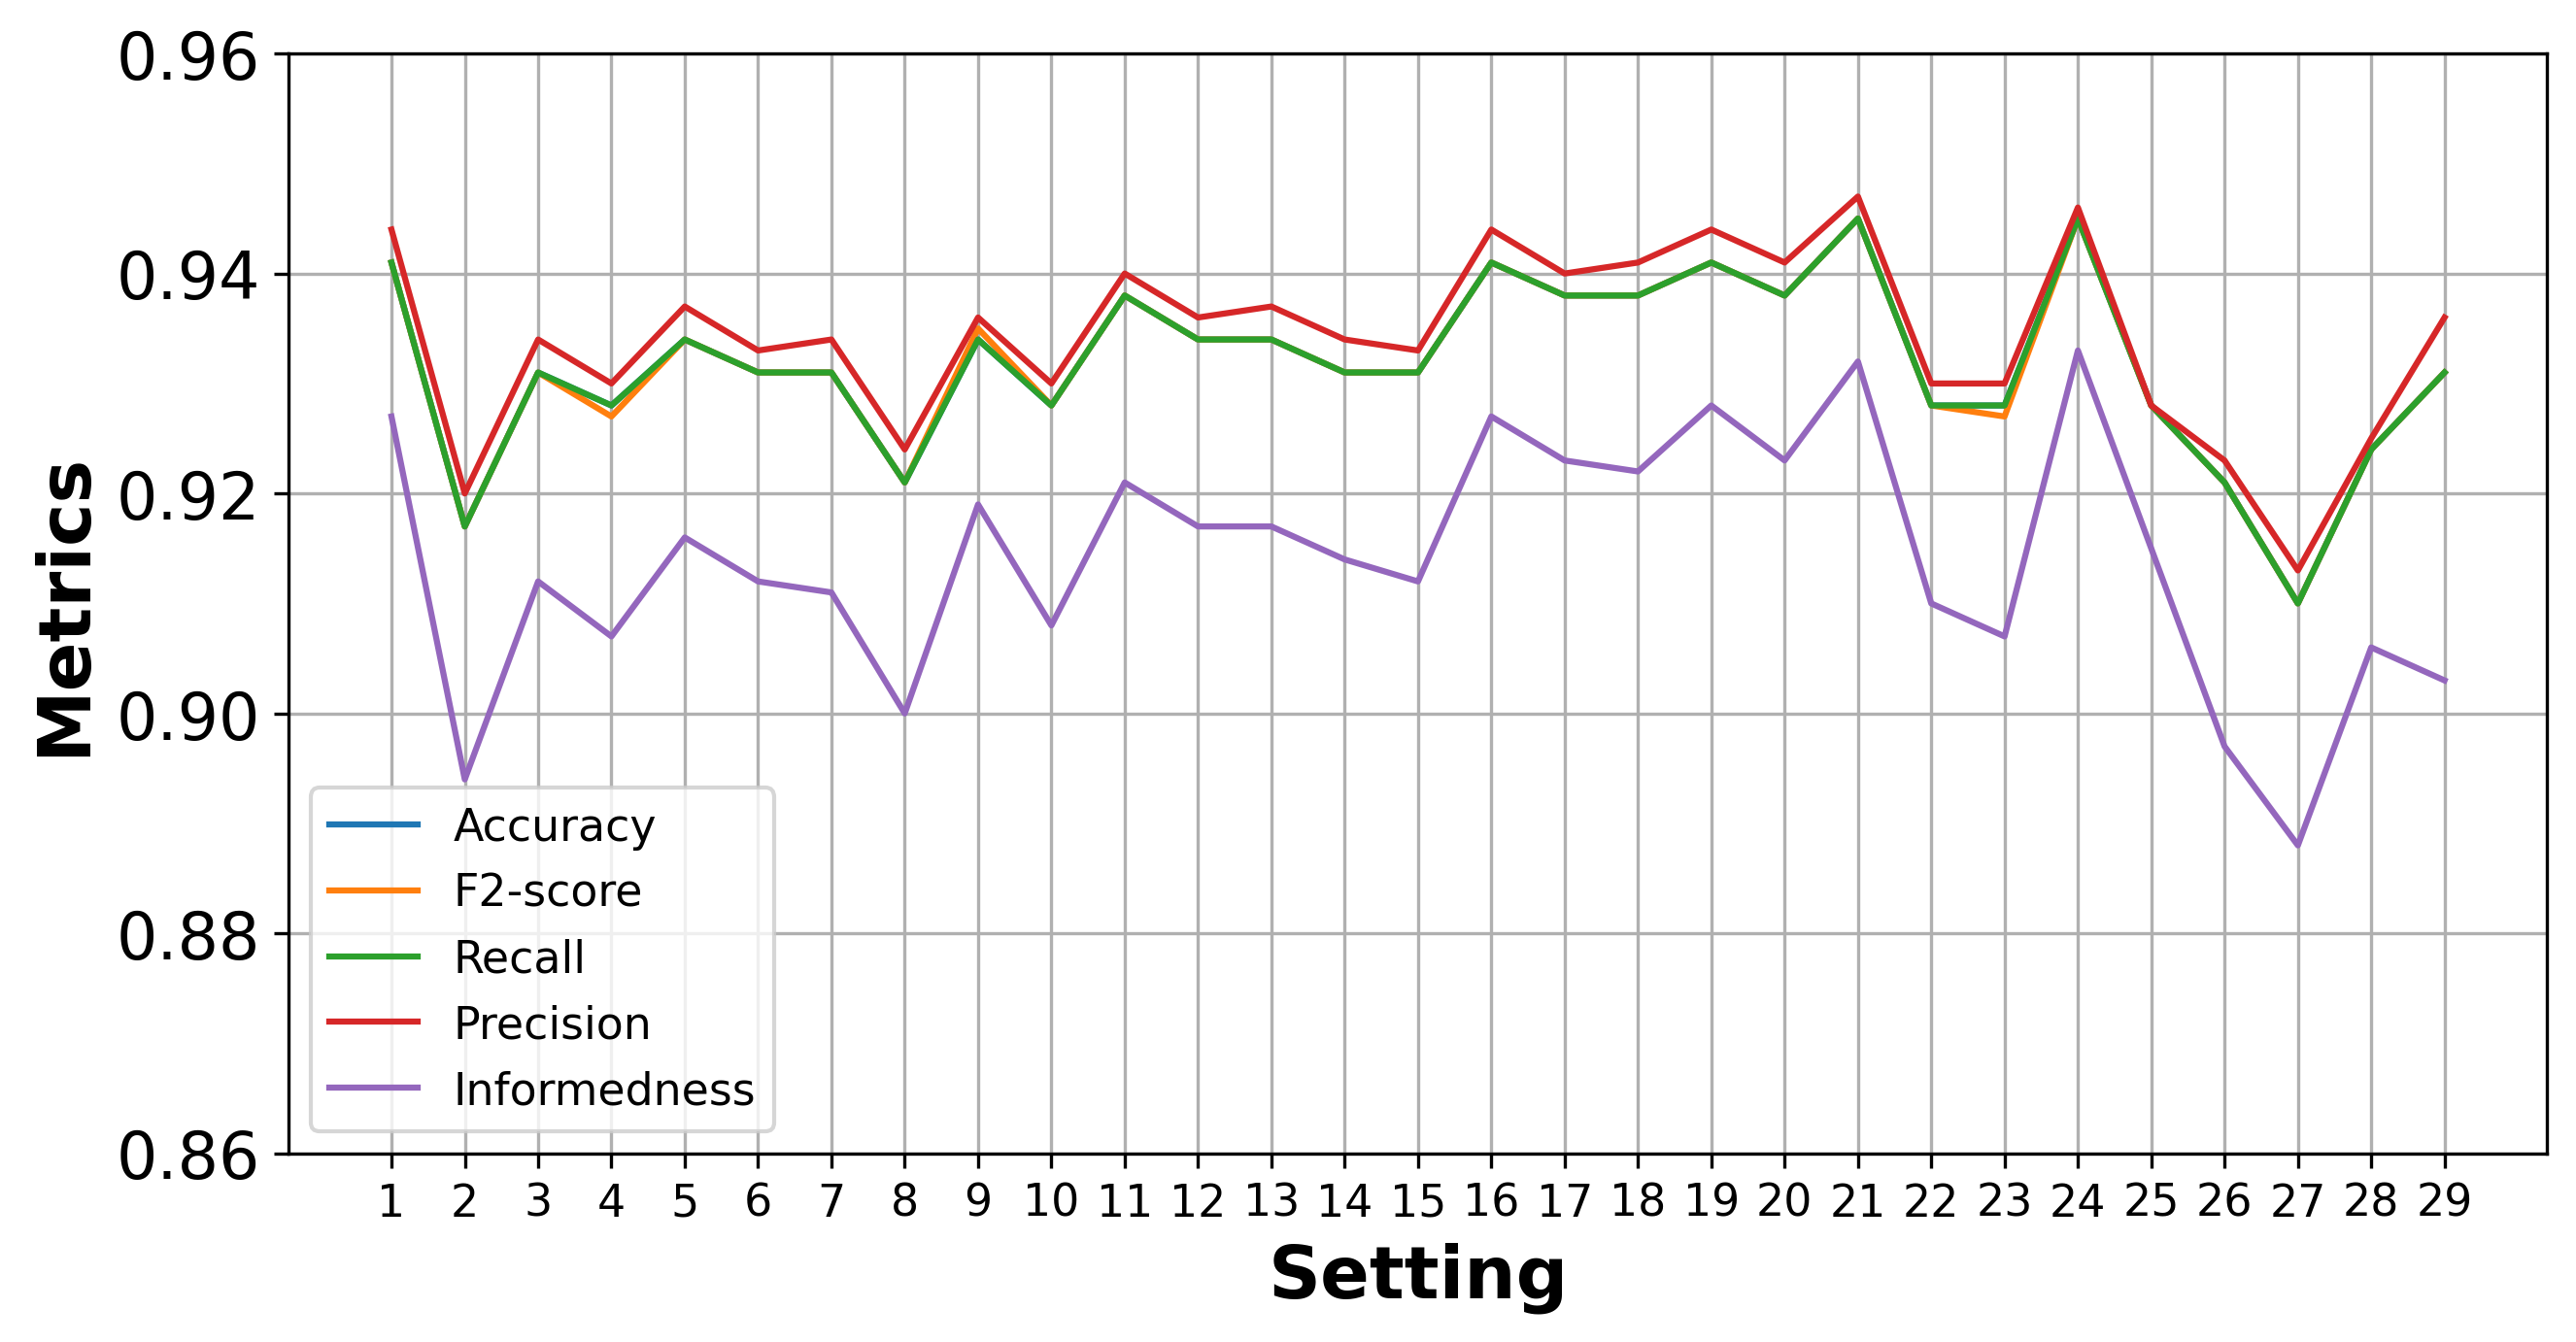

In [72]:
f, ax = plt.subplots(figsize=(10, 5),dpi=300)
ax.set(ylim=(0.86, 0.96))

#plt.plot([1]*6000)
#plt.title('DTR by rank update')
plt.plot(multiclass_ablation_df.index+1, multiclass_ablation_df["Accuracy"])
plt.plot(multiclass_ablation_df.index+1, multiclass_ablation_df["F2-Score"])
plt.plot(multiclass_ablation_df.index+1, multiclass_ablation_df["Recall"])
plt.plot(multiclass_ablation_df.index+1, multiclass_ablation_df["Precision"])
plt.plot(multiclass_ablation_df.index+1, multiclass_ablation_df["Informedness"])
         

plt.xlabel('Setting', fontweight ='bold',fontsize=18)
plt.ylabel('Metrics', fontweight ='bold',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(multiclass_ablation_df.index+1,fontsize=11)
handles, _ = ax.get_legend_handles_labels()    
plt.grid()
plt.legend(["Accuracy", "F2-score", "Recall", "Precision", "Informedness"],loc='lower left',fontsize=11)
plt.savefig('multiclass_ablation_study.pdf')